In [112]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

from apps import cex_toy_generator, cex_toy_parameters
from IPython.display import clear_output
from python.analysis.Master import DictToHDF5, ReadHDF5
from python.analysis import cross_section, Plots
from scipy.stats import norm, lognorm
from statsmodels.stats.weightstats import ztest as ztest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.SetPlotStyle(True, 80)

def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None):
    return {
    "events" : events,
    "step" : 2,
    "p_init" : p_init,
    "beam_profile" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs
    }


def RegionFitToyStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, energy_slice : cross_section.Slices, mean_track_score_bins : np.array = None, pdf : Plots.PlotBook = Plots.PlotBook.null):

    fit_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)
    # if alt_regions is not None:
    #     fit_input.regions = alt_regions

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)
    result = cross_section.RegionFit.Fit(observed, model, False)

    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    #* split post fit results by the observables
    if mean_track_score_bins is not None:
        KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit")
        # mean_track_score_prediction = SliceModelPrediction(postfit_pred, slice(len(model.config.channels) - 1, len(model.config.channels)), "mean_track_score_postfit")
    else:
        KE_int_prediction = postfit_pred

    total_count_err = np.sum(np.power(KE_int_prediction.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(KE_int_prediction.model_yields)
    # total_count_actual = np.sum(prefit_pred.model_yields)
    # total_count_actual = sum((toy.df.inclusive_process != "decay") & (toy.df.KE_int_smeared > min(energy_slice.pos)) & (toy.df.KE_int_smeared < max(energy_slice.pos)))

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    # truth_regions_masksed = {t : toy.truth_regions[t] & (((toy.df.KE_int_smeared) > min(energy_slice.pos)) & ((toy.df.KE_int_smeared) < max(energy_slice.pos))) for t in toy.truth_regions}
    # reco_regions_masksed = {r : toy.reco_regions[r] & (((toy.df.KE_int_smeared) > min(energy_slice.pos)) & ((toy.df.KE_int_smeared) < max(energy_slice.pos))) for r in toy.reco_regions} 
    # counts_matrix = cross_section.Toy.ComputeCounts(truth_regions_masksed, reco_regions_masksed)
    counts_matrix = []
    for j in toy.truth_region_labels:
        counts = []
        for i in toy.reco_region_labels:
            counts.append(sum(toy.NInteract(energy_slice, toy.truth_regions[j], toy.reco_regions[i])))
        counts_matrix.append(counts)
    print(f"{counts_matrix=}")
    total_count_actual = np.sum(counts_matrix)
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False)
    next(plot)
    counts_matrix = []
    for c in KE_int_prediction.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "fitted", newFigure = False)

    print(f"{total_count_actual, total_count, total_count_err=}")

    pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"${n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result



def ModifiedConfigTest(config : dict, energy_slice : cross_section.Slices, model : cross_section.pyhf.Model, toy_template : cross_section.Toy, pdf_name : str = None, mean_track_score_bins : np.array = None):
    if pdf_name is not None:
        pdf = Plots.PlotBook(pdf_name)
        pdf.open()
    else:
        pdf = Plots.PlotBook.null

    toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config))))
    
    obs = cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, mean_track_score_bins, model, False)
    fit_result = cross_section.RegionFit.Fit(obs, model, None, par_bounds = [(0, np.inf)]*4)

    true_process_counts = {}
    for v in toy_alt_pdf.exclusive_process:
        true_process_counts[v] = sum(toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[v]))

    expected_mus = [sum(toy_alt_pdf.exclusive_process[r]) / sum(toy_template.truth_regions[r]) for r in toy_alt_pdf.exclusive_process]

    if pdf_name is not None: Plots.plt.close("all")
    return fit_result, true_process_counts, expected_mus


def PlotFitResults(xlabel, model : cross_section.pyhf.Model, toy_template : cross_section.Toy, results, true_counts, pdf : Plots.PlotBook = Plots.PlotBook.null):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    scale_factors = {k : sum(true_counts[k].values()) / sum(toy_template.df.total_inelastic) for k in true_counts}
    x = list(range(len(results)))

    mu = []
    mu_err = []
    for k in results:
        mu.append(results[k].bestfit[0:4] / scale_factors[k])
        mu_err.append(results[k].uncertainty[0:4] / scale_factors[k])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    process_map = {0 : "abs", 1 : "cex", 2 : "spip", 3 : "pip"}

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{{{process_map[i]}}}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
    Plots.plt.xticks(ticks = x, labels = results.keys())
    Plots.plt.xlabel(xlabel)
    pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, title = f"$\mu_{{{process_map[i]}}}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    true_counts_pred_res = {}
    true_counts_pred_res_err = {}
    for k, v in results.items():
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")

        if any([c["name"] == "mean_track_score" for c in post_fit_pred.model.spec["channels"]]):
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score
        else:
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(0, len(post_fit_pred.model_yields)), "KE_int_postfit")

        true_counts_pred_res_err[k] = np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1]
        true_counts_pred_res[k] = {toy_template.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_template.reco_region_labels))])) - true_counts[k][toy_template.truth_region_labels[j]] for j in range(len(toy_template.truth_region_labels))}

    true_counts = pd.DataFrame(true_counts)
    true_counts_pred_res = pd.DataFrame(true_counts_pred_res)
    true_counts_pred_res_err = pd.DataFrame(true_counts_pred_res_err, index = true_counts_pred_res.index)


    prefit_counts = np.array([np.sum(model.main_model.expected_data(np.array(model.config.suggested_init()) * scale_factors[k], return_by_sample = True), 1) for k in scale_factors]).T


    # plot true process residual
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(x, true_counts_pred_res.loc[i], yerr = true_counts_pred_res_err.loc[i], title = f"$N_{{{process_map[n]}}}^{{pred}}$", xlabel = xlabel, ylabel = "residual", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(x, true_counts_pred_res.loc[i] / true_counts.loc[i], yerr = true_counts_pred_res_err.loc[i] / true_counts.loc[i], title = f"measured $N_{{{process_map[n]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(x, true_counts_pred_res.loc[i] / true_counts.loc[i], yerr = true_counts_pred_res_err.loc[i] / true_counts.loc[i], title = f"$N_{{{process_map[n]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[n], label = "postfit", newFigure = False)
        Plots.Plot(x, (prefit_counts[n] - true_counts.loc[i]) / true_counts.loc[i], title = f"$N_{{{process_map[n]}}}^{{pred}}$", linestyle = "", marker = "o", color = "k", label = "measured", newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    Plots.plt.figure()
    for n, i in enumerate(true_counts.index):
        Plots.Plot(x, true_counts_pred_res.loc[i] / true_counts.loc[i], yerr = true_counts_pred_res_err.loc[i] / true_counts.loc[i], label = f"${process_map[n]}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        plt.ylim(-1, 1)
    Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [3]:
toy_template = cross_section.Toy(file = "work/2023/toys/xs_toy_cb_template.hdf5")

In [4]:
energy_range = [0, 1000]
energy_slice = cross_section.Slices(50, min(energy_range), max(energy_range), True)

energy_overflow =  np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)

mean_track_score_bins = np.linspace(0, 1, 21, True)

model, templates_energy, tempalates_mean_track_score = cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, None, True, None, False)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [73]:
pseudo_experiment = model.make_pdf(cross_section.pyhf.tensorlib.astensor(model.config.suggested_init())).sample((100, ))

pulls = []
for e in pseudo_experiment:
    result = cross_section.RegionFit.Fit(e / 10, model, None, [(0, np.inf)]*4, False)
    pull = ((10 * result.bestfit) - model.config.suggested_init()) / (10 * result.uncertainty)
    pulls.append(pull)
pulls = np.array(pulls)

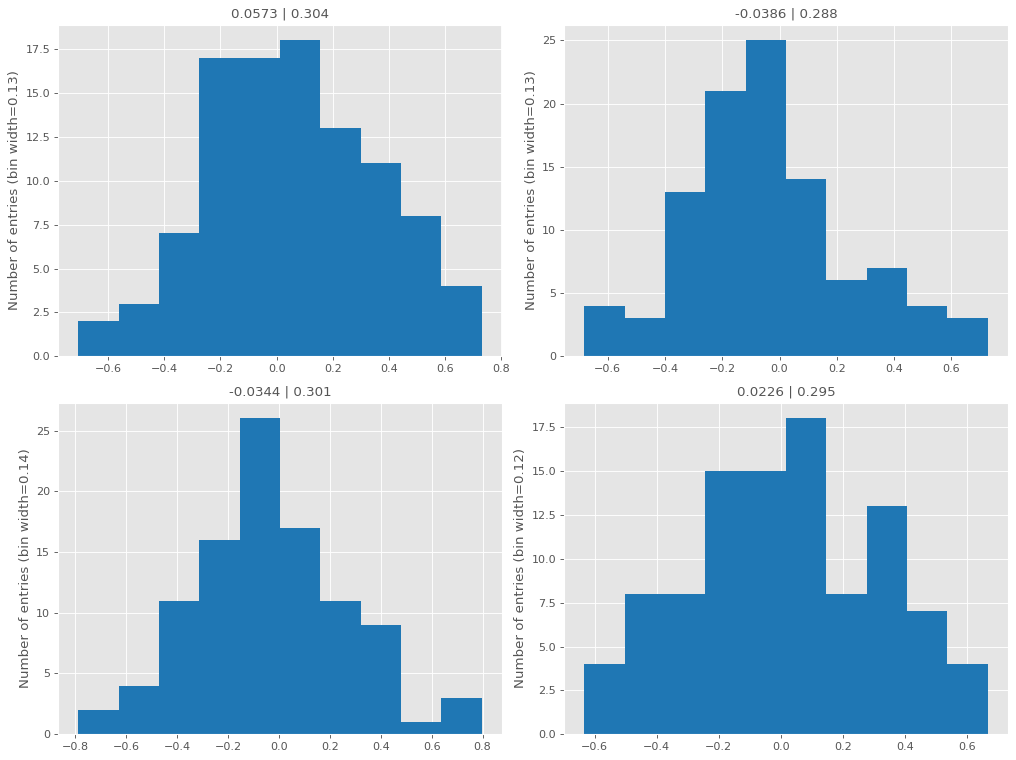

In [74]:
for i in Plots.MultiPlot(4):
    Plots.PlotHist(pulls[:, i], bins = 10, title = f"{np.mean(pulls[:, i]):.3g} | {np.std(pulls[:, i]):.3g}", newFigure = False)

# Templates

TypeError: 'NoneType' object is not iterable

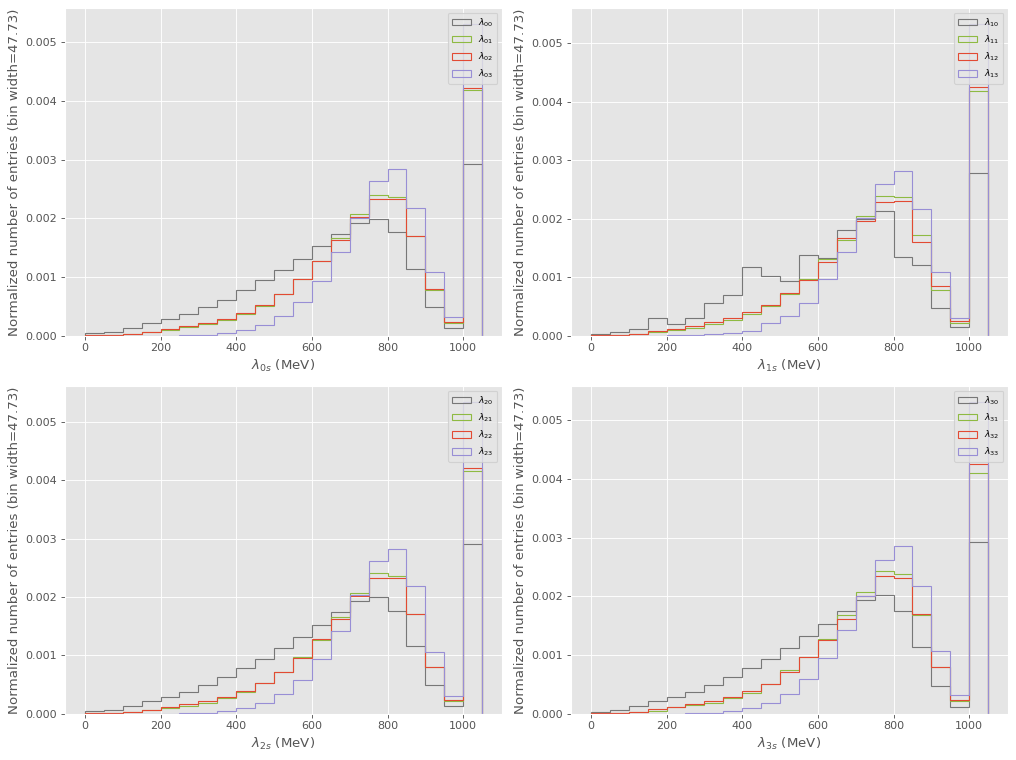

<Figure size 512x384 with 0 Axes>

In [4]:
pdf = Plots.PlotBook("fit_templates.pdf", False)

tags = cross_section.Tags.ExclusiveProcessTags(toy_template.truth_regions)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(energy_overflow, energy_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = True)
pdf.Save()

plt.figure()
for i, s in enumerate(tempalates_mean_track_score):
    Plots.PlotHist(cross_section.bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
plt.legend(loc = "upper left")
pdf.Save()
pdf.close()

# Validation test

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-522.28890785])
init_params=False
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([1.00013775, 0.9994995 , 0.99984788, 1.00040049])
uncertainty=array([0.0018245 , 0.00332153, 0.00187331, 0.00495383])
result=FitResults(bestfit=array([1.00013775, 0.9994995 , 0.99984788, 1.00040049]), uncertainty=array([0.0018245 , 0.00332153, 0.00187331, 0.00495383]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.69022574 -0.58329556  0.41479101]
 [-0.69022574  1.          0.4705639  -0.60586613]
 [-0.58329556  0.4705639   1.         -0.84892524]
 [ 0.41479101 -0.60586613 -0.84892524  1.        ]], best_twice_nll=1044.5455933849205, goodness_of_fit=-1, minos_uncertainty={})


counts_matrix=[[2234453, 689, 546359, 104276], [1096987, 151664, 170206, 40808], [1601396, 21051, 2169314, 287859],
[673487, 48675, 577943, 202868]]

total_count_actual, total_count, total_count_err=(9928035, 9928035.271261547, 9309.712993558727)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.000138  0.999500  0.999848  1.000400
error  0.001824  0.003322  0.001873  0.004954

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


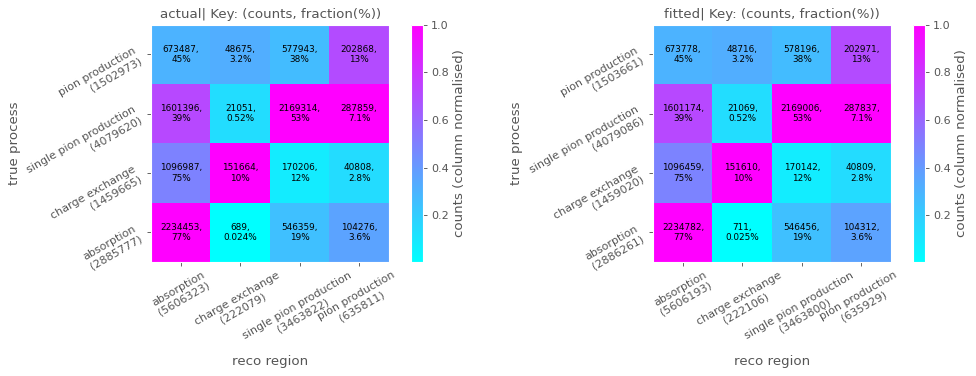

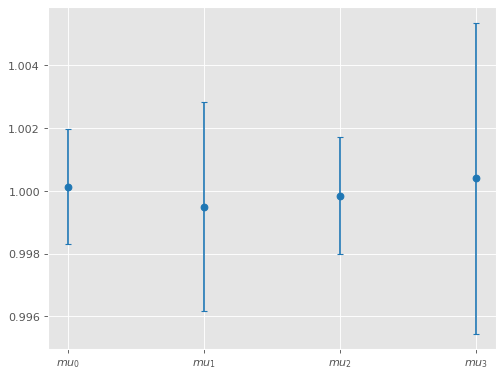

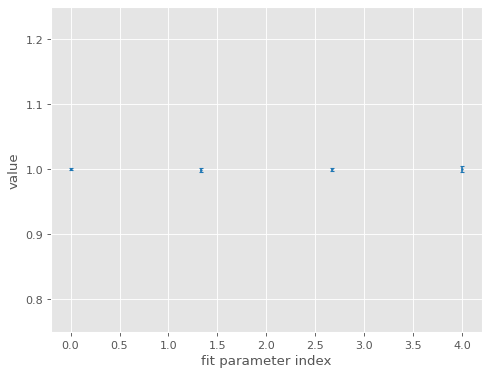

In [18]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitToyStudy(toy_template, model, energy_slice, None, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [5]:
# toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1))), smearing = True)
toy_observed = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_PDSP_stats.hdf5")

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


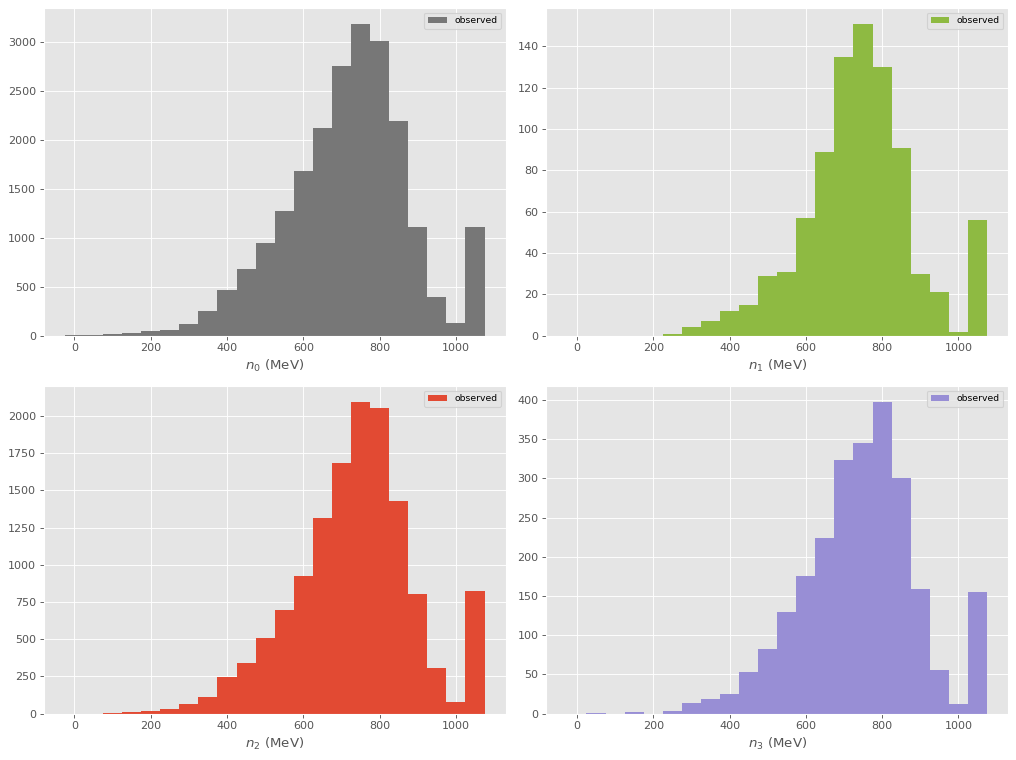

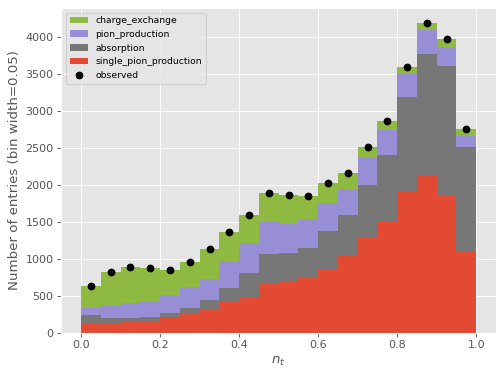

In [9]:
pdf = Plots.PlotBook("toy_observations.pdf", False)
tags = cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions)

for tag in tags:
    tags[tag].mask = tags[tag].mask & toy_observed.df.beam_selection_mask

n_obs = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, mean_track_score_bins)
n_obs_energy = n_obs[:-1]
n_obs_mean_track_score = n_obs[-1]
for i, r in Plots.IterMultiPlot(toy_observed.reco_region_labels):
    Plots.Plot(energy_overflow, n_obs_energy[i], xlabel = f"$n_{{{i}}}$ (MeV)", marker = "o", color = tags[r].colour, linestyle = "-", label = "observed", style = "bar", newFigure = False)
pdf.Save()

Plots.PlotTagged(toy_observed.df.mean_track_score, tags, mean_track_score_bins)
Plots.Plot(cross_section.bin_centers(mean_track_score_bins), n_obs_mean_track_score, xlabel = "$n_{t}$", marker = "o", color = "black", linestyle = "", label = "observed", newFigure = False)
pdf.Save()
pdf.close()

pdf toy_fit_low_stats.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

counts_matrix=[[8463, 5, 2086, 401], [4281, 594, 682, 164], [6213, 69, 8513, 1081], [2629, 193, 2259, 831]]

total_count_actual, total_count, total_count_err=(38464, 38453.49209334142, 489.1448673382426)

$mu_0$    $mu_1$    $mu_2$   $mu_3$
value  0.008886  0.008339  0.009001  0.00964
error  0.000217  0.000345  0.000242  0.00062

pdf toy_fit_low_stats.pdf has been closed


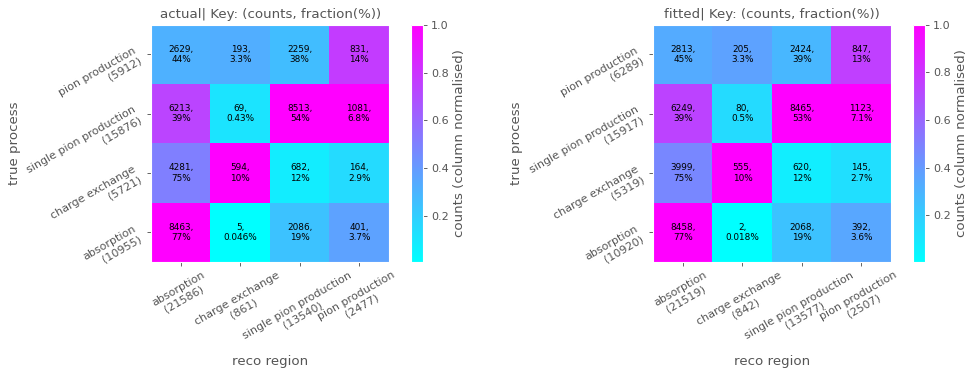

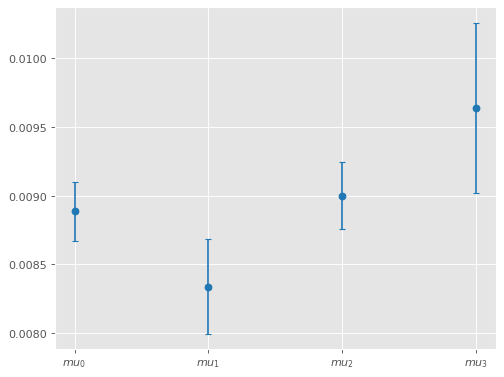

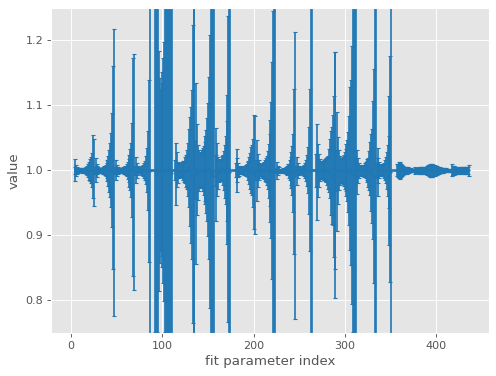

In [13]:
pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", True)
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [6]:
toy_alt = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
fractions = cross_section.ReadHDF5("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_template.df.exclusive_process, fractions, np.random.default_rng())
toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.369524  
pion_production                0.129529

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.119524  
pion_production                0.379529

'GenerateRecoRegions' executed in 15.3544s

In [9]:
cross_section.AnalysisInput.CreateAnalysisInputToy(toy_alt)

RegionFit.FitInput(regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}, outside_tpc=array([False, False, False, ..., False, False, False]), KE_int=array([790.78735067, 855.76283972, 846.89393684, ..., 792.53907374,
       808.40776848, 726.85612174]), KE_init=array([878.43655808, 827.73892447, 934.21780807, ..., 922.71766467,
       939.86234677, 802.99491719]), mean_track_score=array([0.7491085464398641, 0.631785005006679, 0.548571686403099, ...,
       0.794598364795846, 0.4354737227453884, 0.8886725692151805],
      dtype=object))

fit_input.regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

counts_matrix=[[1826895, 570, 473524, 113995], [899530, 111561, 124753, 29515], [1423759, 15303, 1583047, 210654], 
[510551, 33788, 129983, 412788]]

total_count_actual, total_count, total_count_err=(7900216, 7898231.532061219, 11216.25780495737)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.391489  0.439683  0.451176  2.346546
error  0.002833  0.004277  0.003159  0.008264

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


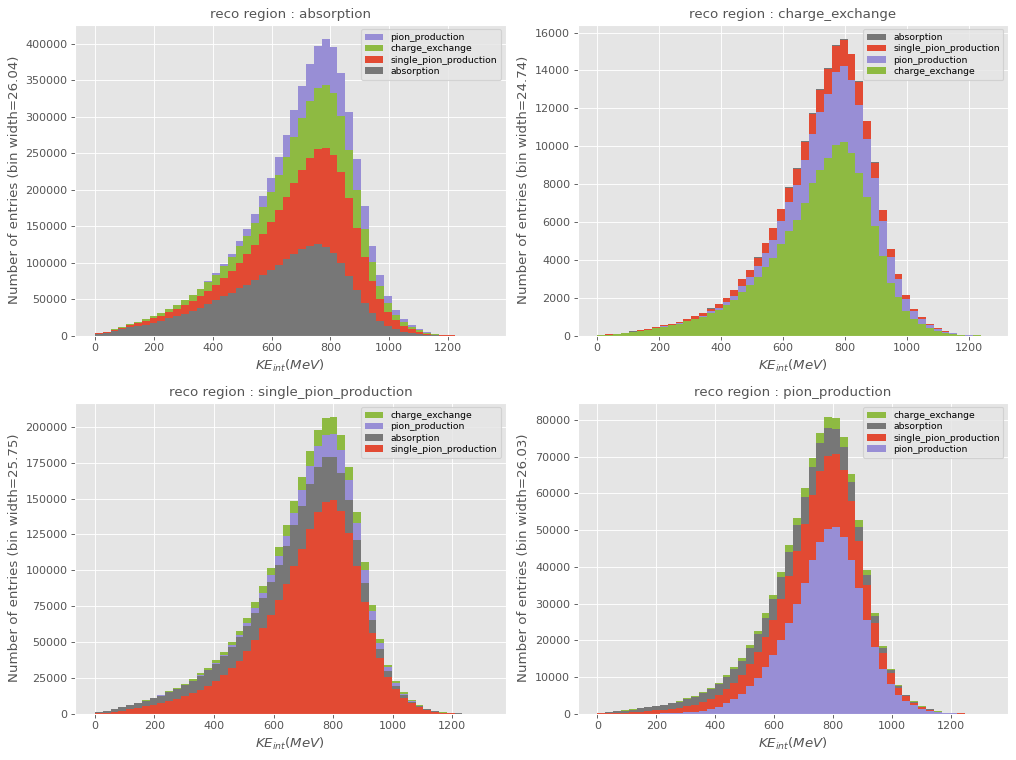

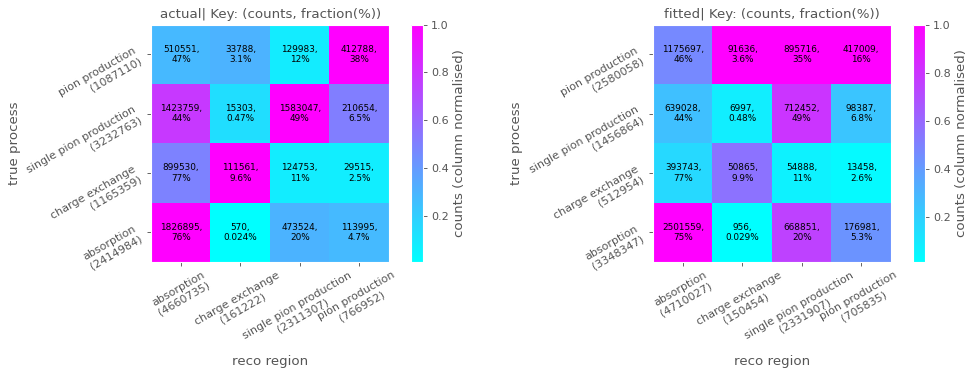

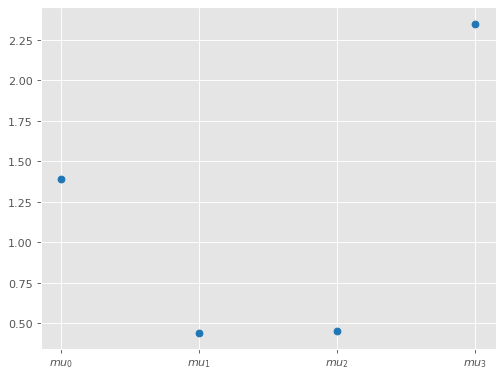

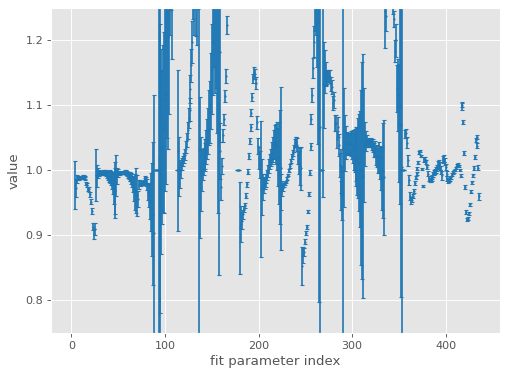

In [14]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled")
result = RegionFitToyStudy(toy_alt, model, energy_slice, mean_track_score_bins, pdf = pdf)
pdf.close()

# Modified exclusive process rates

In [6]:
def PlotObservedToy(scales : dict[int]):
    toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales))))
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
    Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins)
    Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, histtype = "step", reverse_sort = True)

## original PDFs

Simulating |████████████████████████████████████████| 1/1 [100%] in 1.3s (0.77/s) 


'BeamSelectionEfficiency' executed in 0.0060s

'GenerateRecoRegions' executed in 0.0534s

'MeanTrackScore' executed in 0.3032s

'main' executed in 1.8808s

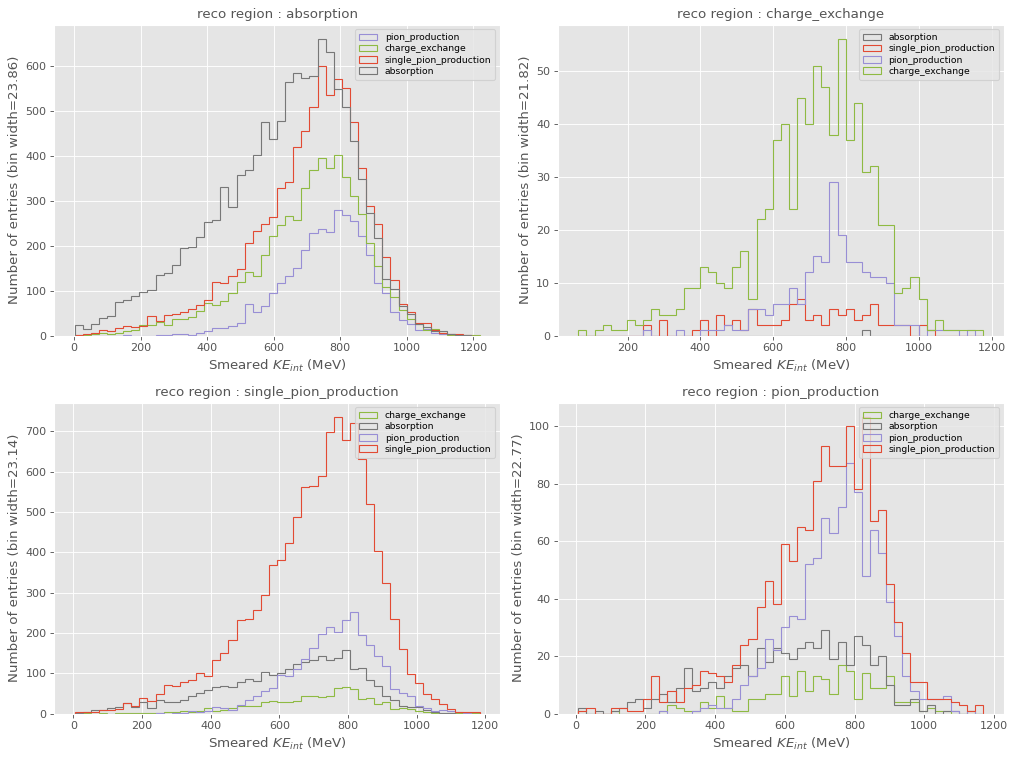

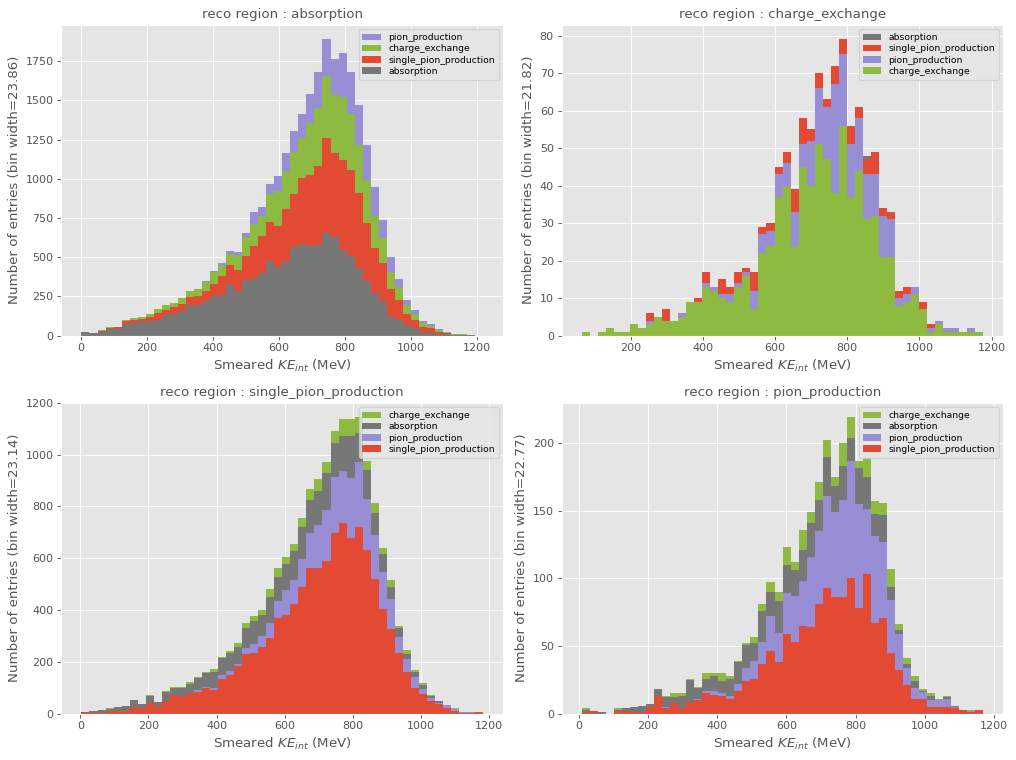

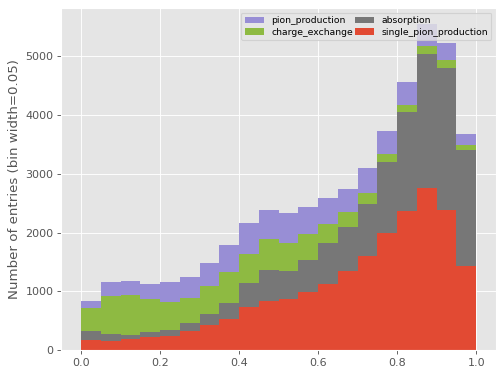

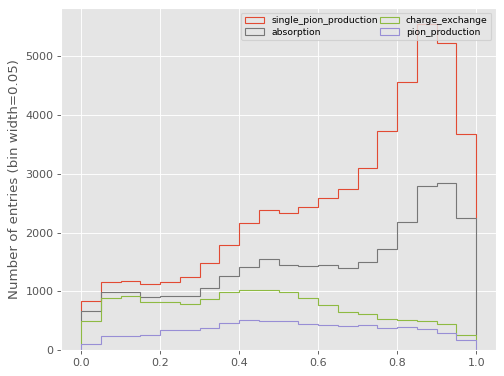

In [7]:
PlotObservedToy(None)

## modified PDFs

Simulating |████████████████████████████████████████| 1/1 [100%] in 1.3s (0.75/s) 


'BeamSelectionEfficiency' executed in 0.0073s

'GenerateRecoRegions' executed in 0.0599s

'MeanTrackScore' executed in 0.2782s

'main' executed in 1.8646s

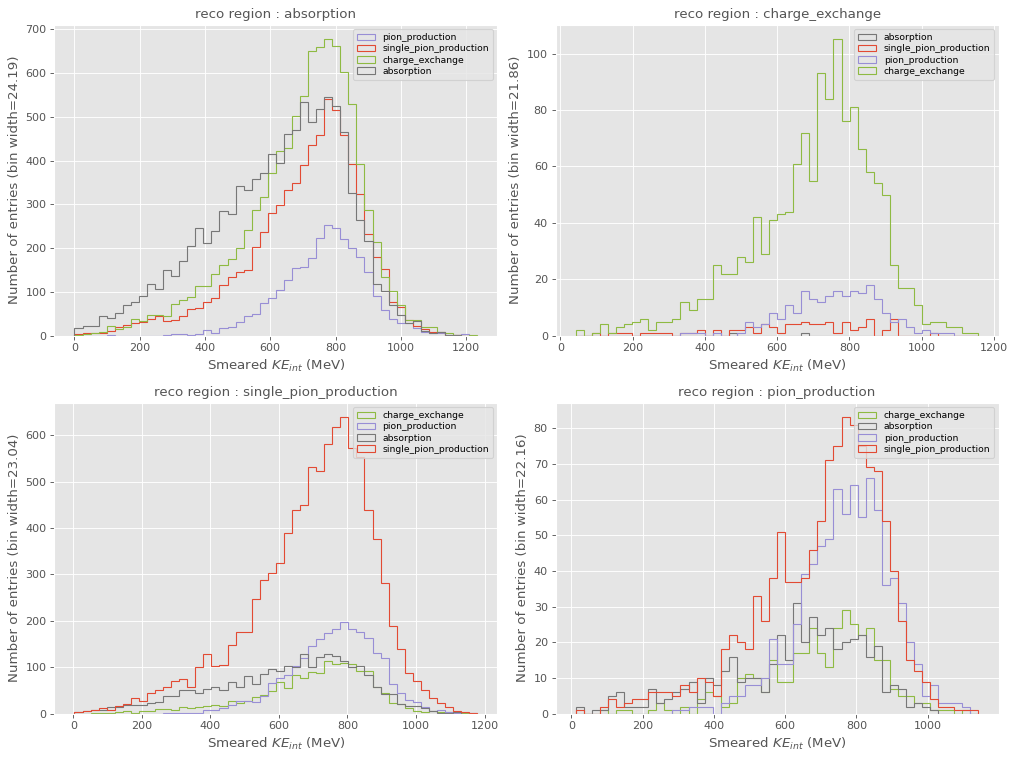

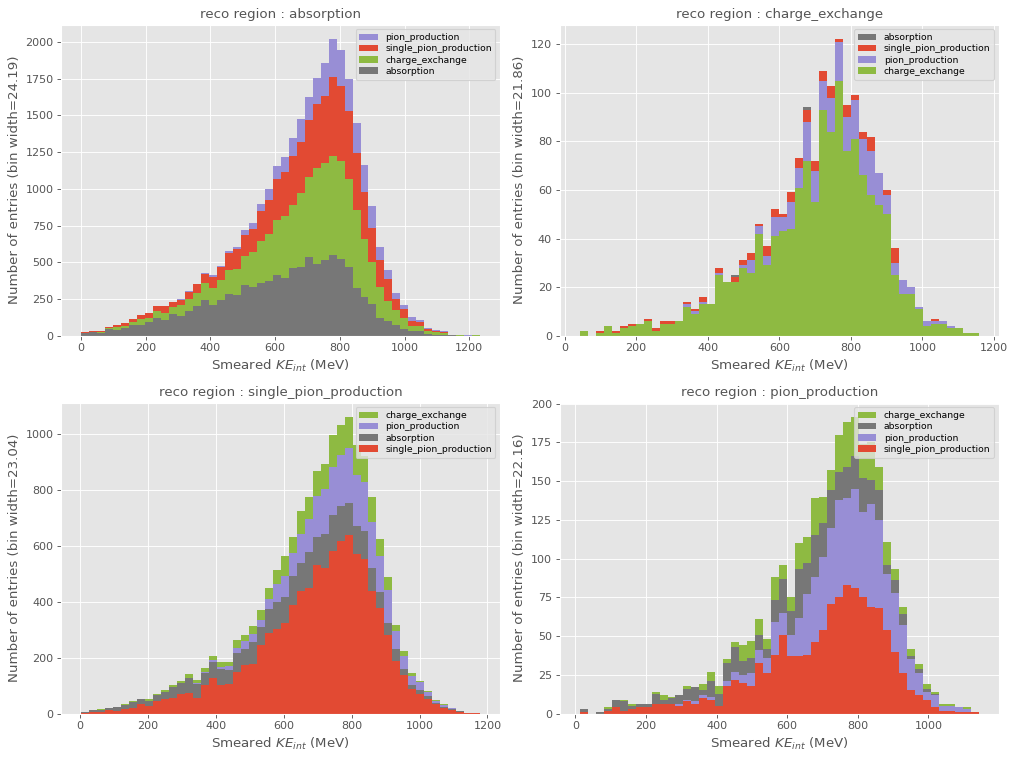

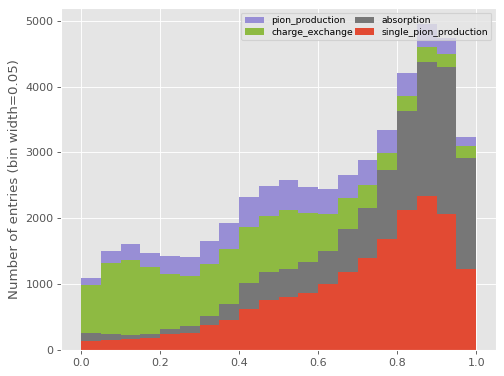

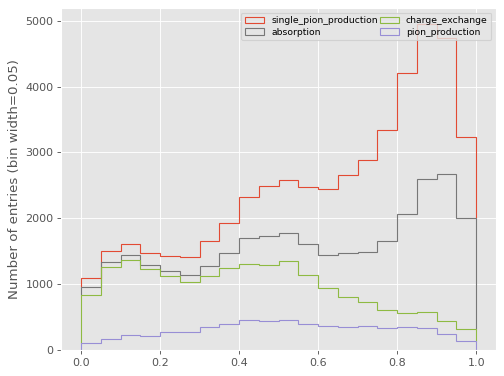

In [8]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 2,
    'double_charge_exchange': 1,
    'pion_production': 1
    }
PlotObservedToy(scales)

## Compare shapes

pdf shape_comparison.pdf has been closed


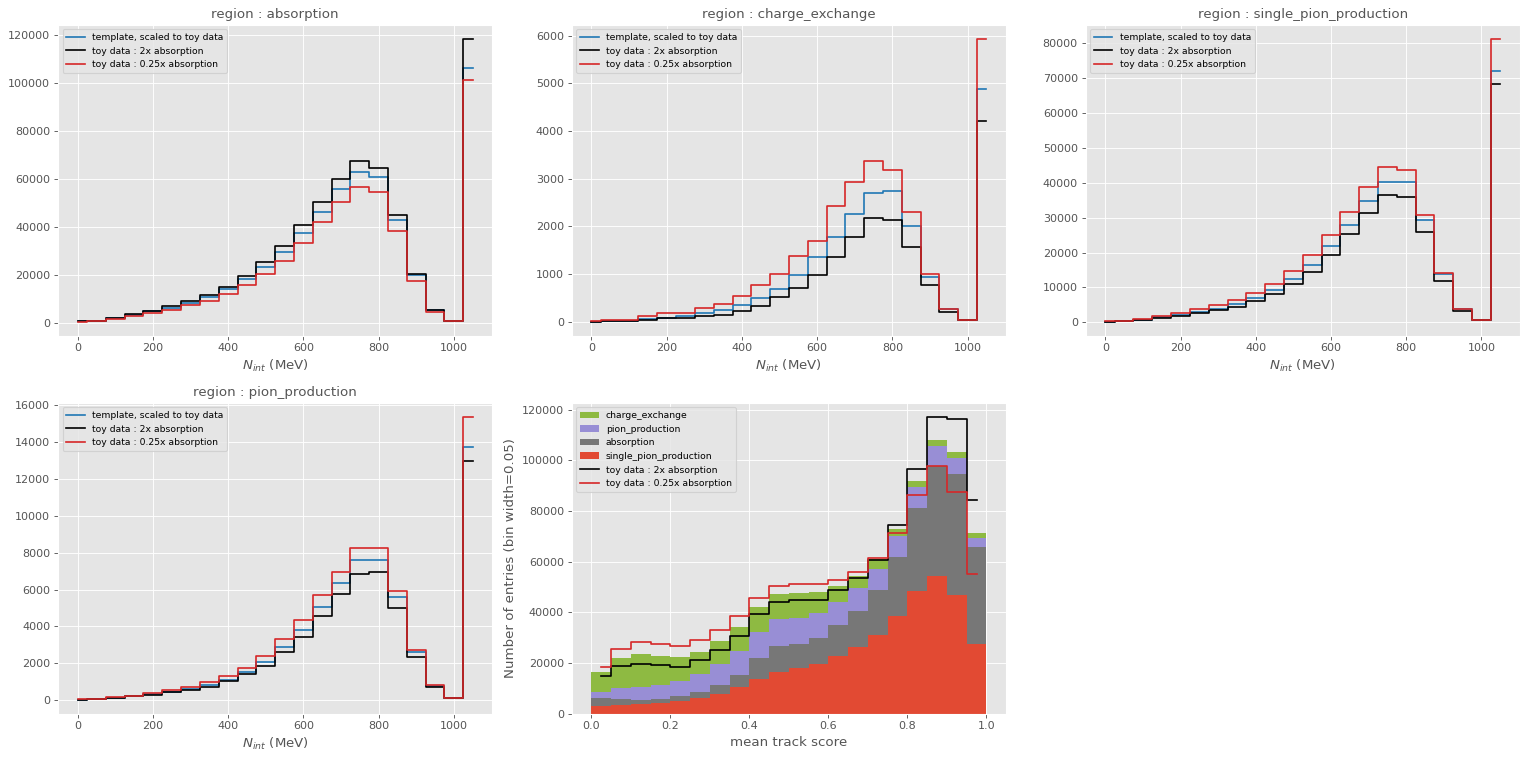

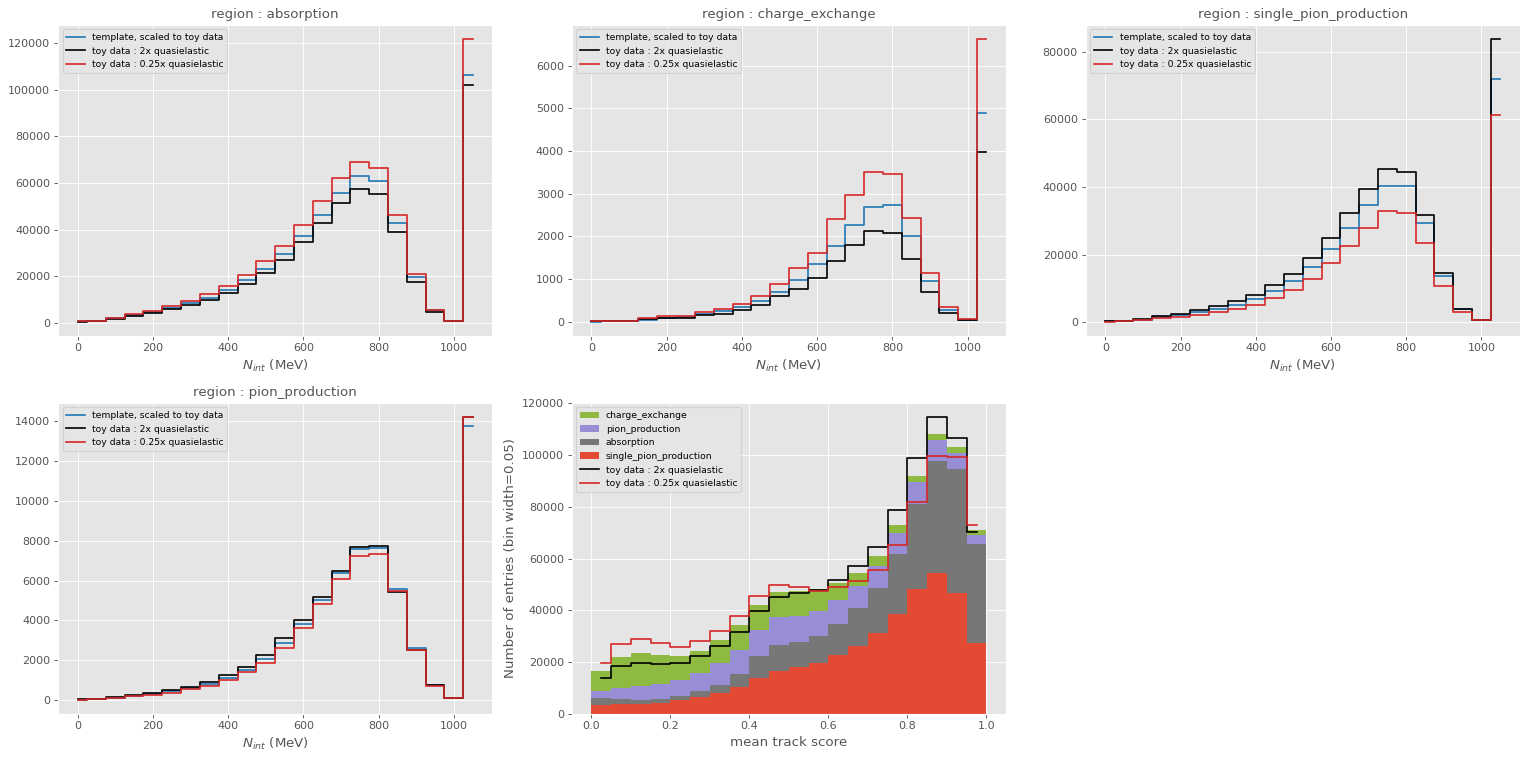

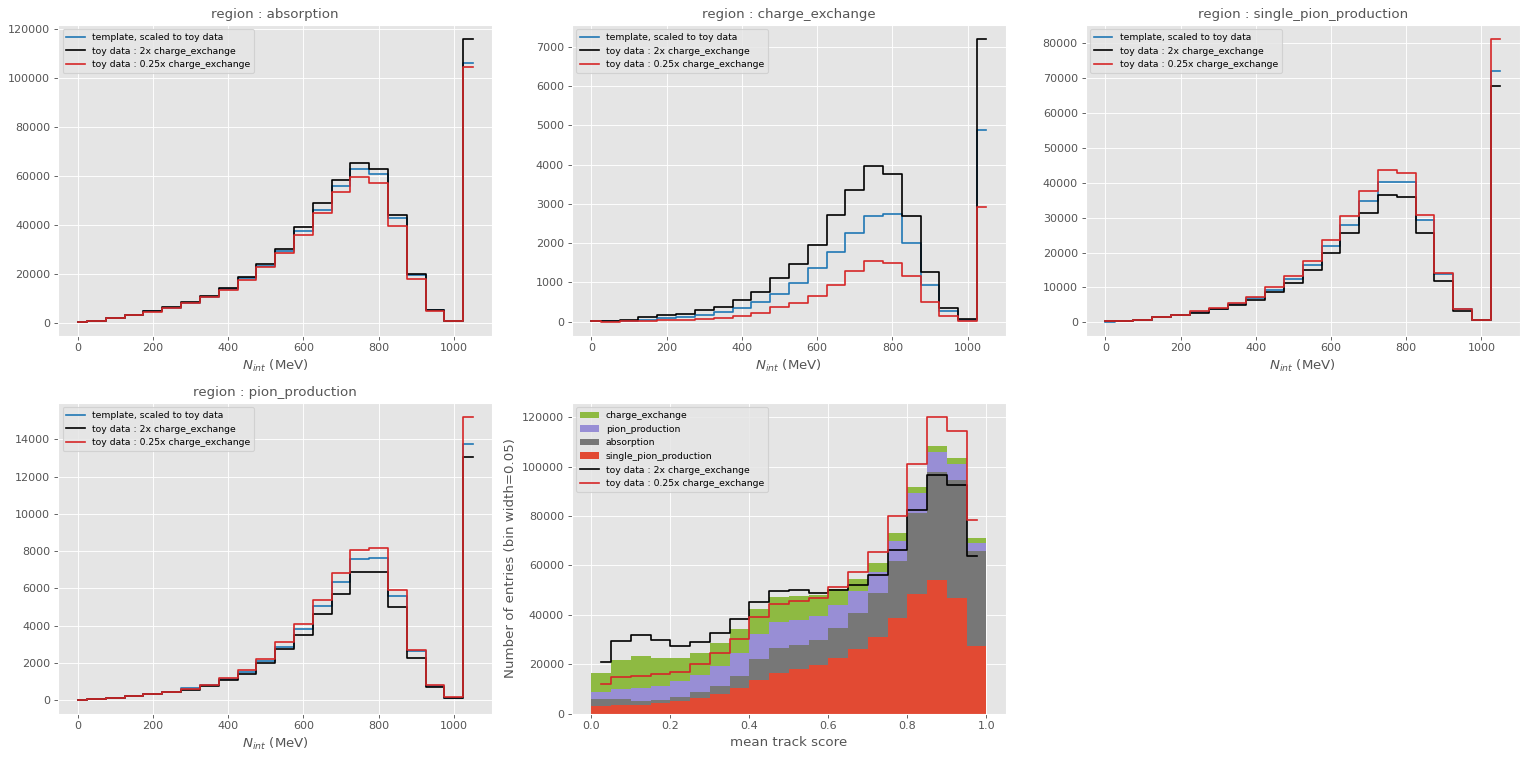

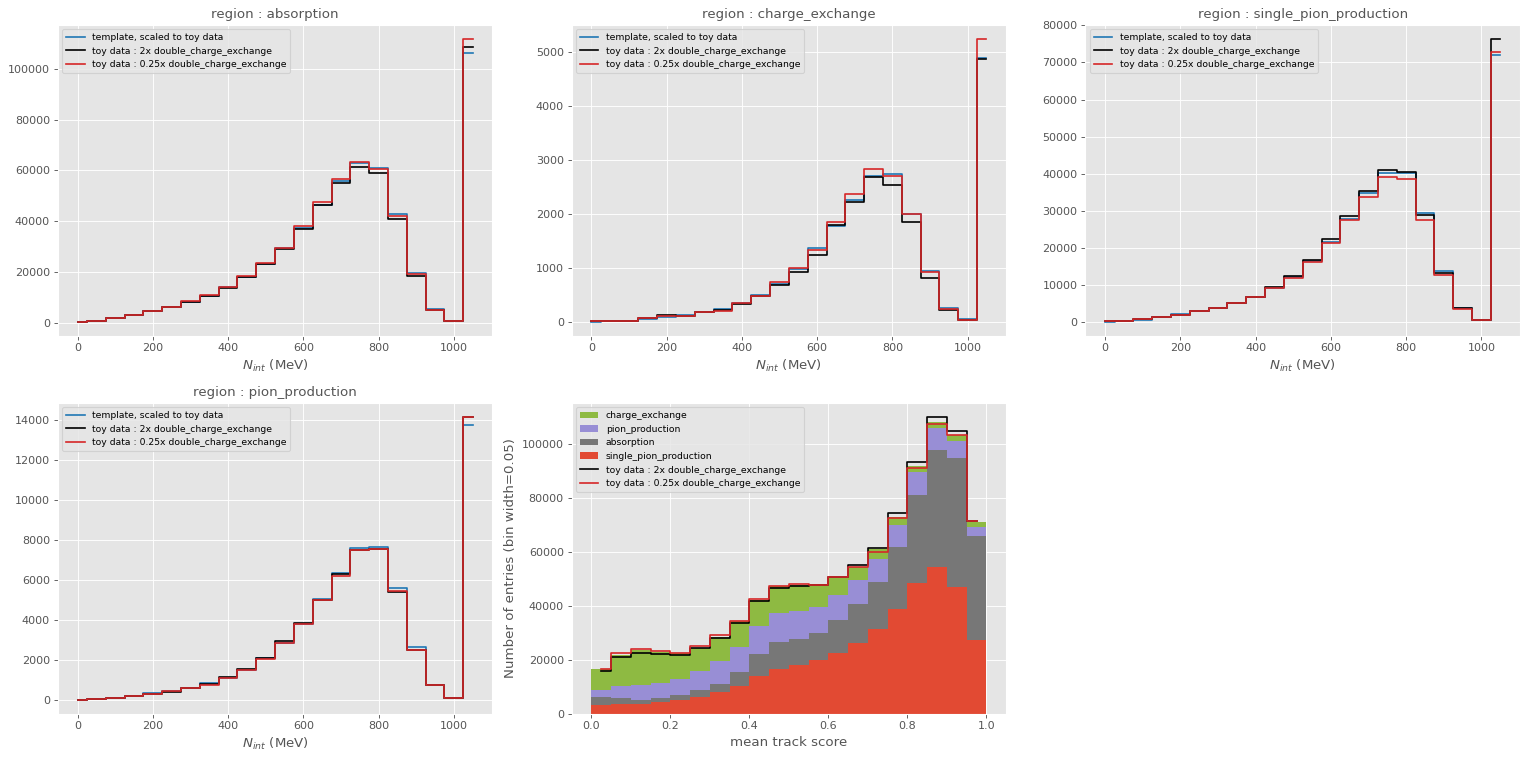

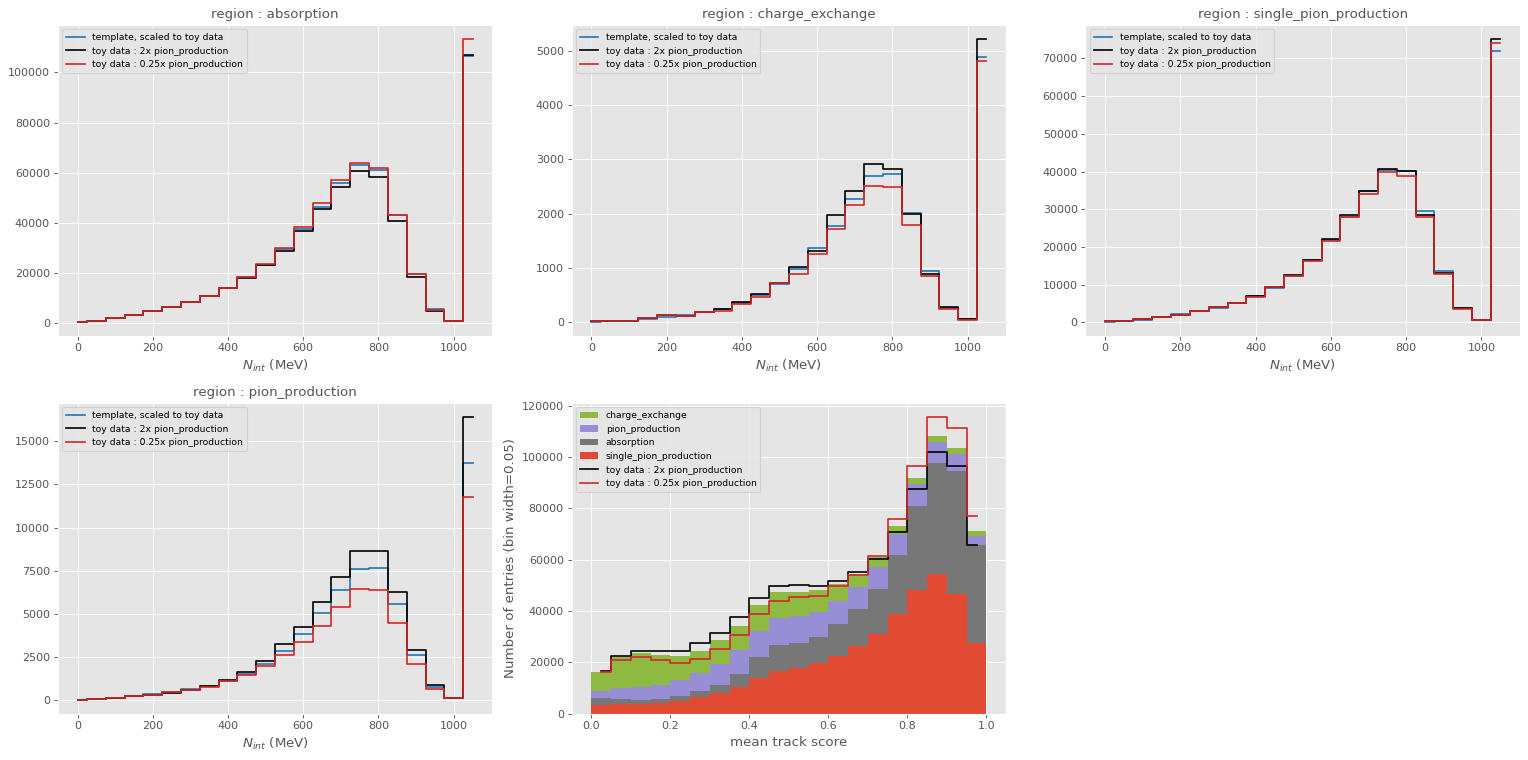

In [51]:
def CompareShapes(events : int, mean_track_score_bins : np.array = None, book : Plots.PlotBook = Plots.PlotBook.null):
    scale = events / len(toy_template.df)
    scales = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}

    n_int_temp = {r : toy_template.NInteract(energy_slice, toy_template.reco_regions[r]) for r in toy_template.reco_region_labels}
    if mean_track_score_bins is not None:
        mean_track_score_temp = np.histogram(toy_template.df.mean_track_score, bins = mean_track_score_bins)[0]

    n_channels = len(toy_template.reco_region_labels) + int(mean_track_score_bins is not None)

    tags = cross_section.Tags.ExclusiveProcessTags(toy_template.truth_regions)

    colors = ["k", "C6"]

    for p in scales:
        scales_low = dict(scales)
        scales_high = dict(scales)

        scales_low[p] = 0.25
        scales_high[p] = 2
        toys = {k : cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = s, seed = 1, events = events)))) for k, s in zip([f"toy data : 2x {p}", f"toy data : 0.25x {p}"], [scales_high, scales_low])}
        clear_output()

        multiplot = Plots.MultiPlot(n_channels)
        for r in toy_template.reco_region_labels:
            next(multiplot)
            Plots.Plot(energy_overflow, scale * n_int_temp[r], newFigure = False, style = "step", title = f"region : {r}", label = "template, scaled to toy data", xlabel = "$N_{int}$ (MeV)")
            for i, (k, v) in enumerate(toys.items()):
                n_int = v.NInteract(energy_slice, v.reco_regions[r])
                Plots.Plot(energy_overflow, n_int, newFigure = False, style = "step", label = k, color = colors[i])
        
        if mean_track_score_bins is not None:
            next(multiplot)
            Plots.PlotTagged(toy_template.df.mean_track_score.values, tags = tags, bins = mean_track_score_bins, newFigure = False, x_label = "mean track score", data_weights = scale * np.ones(len(toy_template.df)))
            for i, (k, v) in enumerate(toys.items()):
                mean_track_score = np.histogram(v.df.mean_track_score, bins = mean_track_score_bins)[0]
                Plots.Plot(cross_section.bin_centers(mean_track_score_bins), mean_track_score, newFigure = False, style = "step", label = k, color = colors[i])

        book.Save()

with Plots.PlotBook("shape_comparison.pdf", True) as book:
    CompareShapes(1E6, mean_track_score_bins, book)

In [116]:
folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}

for target in folder:
    print(target)

    results = {}
    true_counts = {}
    expected_mus = {}
    dire = f"test/region_fit_tests/"
    scales = {
        'absorption': 1,
        'quasielastic': 1,
        'charge_exchange': 1,
        'double_charge_exchange': 1,
        'pion_production': 1
        }
    config = CreateConfig(scale_factors = scales, seed = 1, events = 1E6)
    for i in [0.25, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2]:
        scales[target] = i
        results[i], true_counts[i], expected_mus[i] = ModifiedConfigTest(config, energy_slice, model, toy_template, None, None)
        clear_output()
        print(target)
    
    with Plots.PlotBook(f"{dire}fit_results_{folder[target]}.pdf", True) as pdf:
        cross_section.SaveObject(f"{dire}fit_results_{folder[target]}.dill", {"results" : results, "true_counts" : true_counts, "expected_mus" : expected_mus}) # keep results for future reference
        PlotFitResults(f"{target} normalisation", model, toy_template, results, true_counts, pdf)
    Plots.plt.close("all")

pion_production

pdf test/region_fit_tests/fit_results_pip.pdf has been opened
pdf test/region_fit_tests/fit_results_pip.pdf has been closed


## Fits for different rates

In [181]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 1,
    'double_charge_exchange': 1,
    'pion_production': 1
    }
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales, events = 1E6)))))
obs = cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, None, model, False)
fit_result = cross_section.RegionFit.Fit(obs, model, None, False)

postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = fit_result)


Simulating |████████████████████████████████████████| 10/10 [100%] in 33.5s (0.30/s) 


'BeamSelectionEfficiency' executed in 0.0542s

'GenerateRecoRegions' executed in 1.6650s

'MeanTrackScore' executed in 4.2205s

'main' executed in 42.8782s

poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.10060337, 0.10127397, 0.10136302, 0.09399933])
uncertainty=array([0.00057765, 0.00104906, 0.0005951 , 0.00157168])


pdf toy_obs_nominal.pdf has been opened
pdf toy_obs_nominal.pdf has been closed


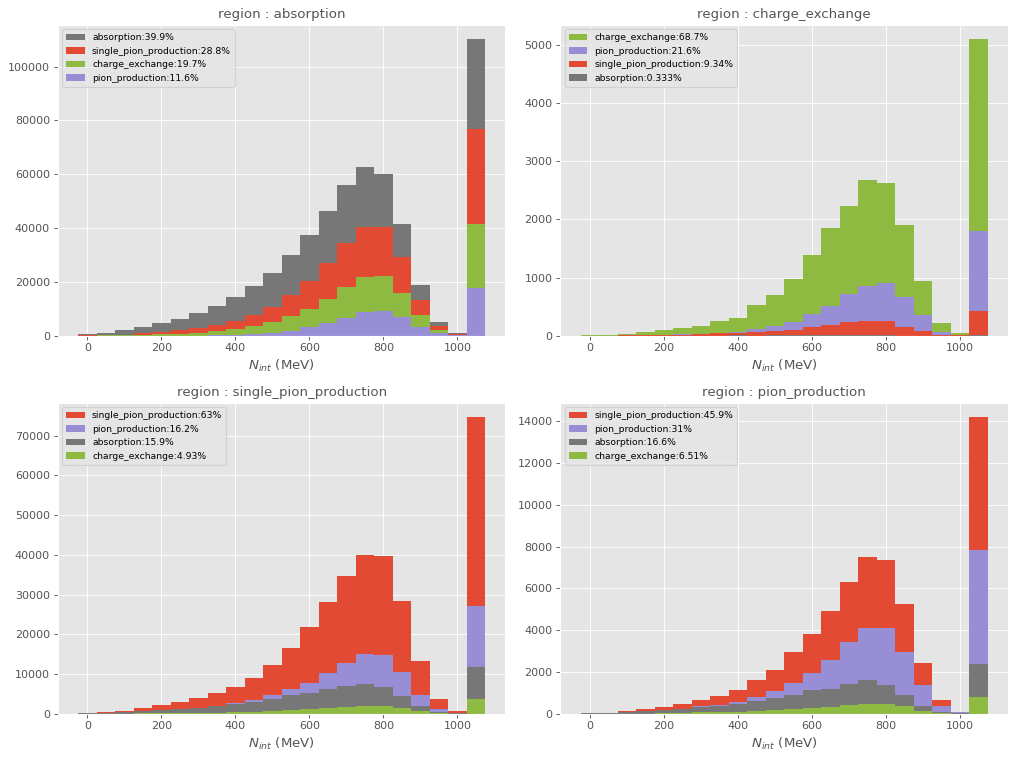

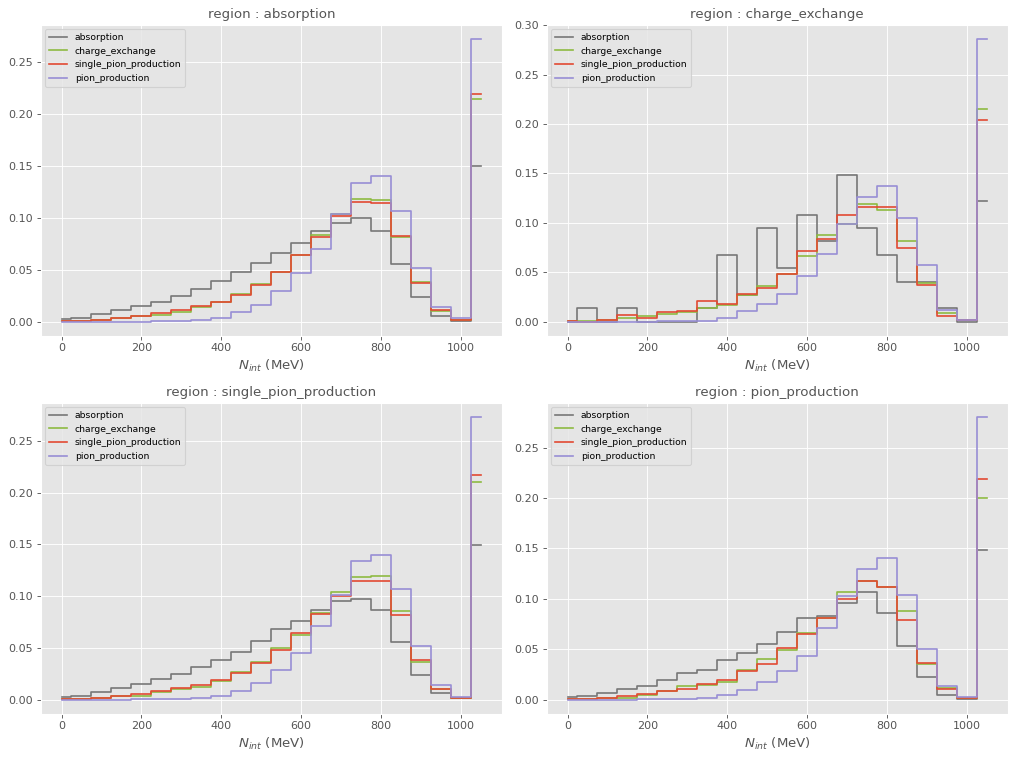

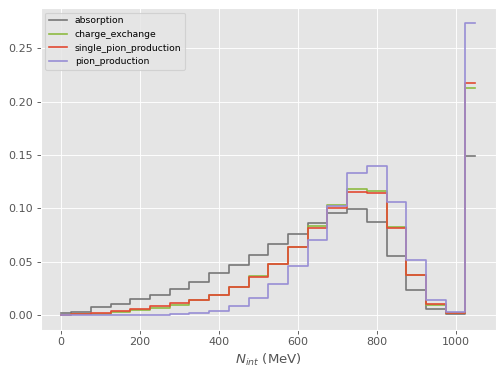

In [193]:
tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.exclusive_process)

with Plots.PlotBook("toy_obs_nominal.pdf", True) as pdf:
    for i, c in Plots.IterMultiPlot(toy_alt_pdf.regions):
        hists = {s : toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s], toy_alt_pdf.regions[c]) for s in toy_alt_pdf.exclusive_process}

        sorted_proc = [list(toy_alt_pdf.exclusive_process.keys())[j] for j in np.argsort([sum(h) for h in hists.values()])]

        total = np.zeros_like(energy_overflow)
        stacked_hists = {}
        for s in sorted_proc:
            total = total + hists[s]
            stacked_hists[s] = total

        for s in reversed(stacked_hists):
            purity = sum(toy_alt_pdf.exclusive_process[s] & toy_alt_pdf.regions[c]) / sum(toy_alt_pdf.regions[c])
            Plots.Plot(energy_overflow, stacked_hists[s], newFigure = False, label = s + f":{100*purity:.3g}%", color = tags[s].colour, style = "bar", xlabel = "$N_{int}$ (MeV)", title = f"region : {c}")
    pdf.Save()

    for i, c in Plots.IterMultiPlot(toy_alt_pdf.regions):
        hists = {s : toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s], toy_alt_pdf.regions[c]) for s in toy_alt_pdf.exclusive_process}
        for s in hists:
            Plots.Plot(energy_overflow, hists[s] / sum(hists[s]), newFigure = False, label = s, color = tags[s].colour, style = "step", xlabel = "$N_{int}$ (MeV)", title = f"region : {c}")
    pdf.Save()


    plt.figure()
    for s in toy_alt_pdf.exclusive_process:
        hists = toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s])
        Plots.Plot(energy_overflow, hists / sum(hists), newFigure = False, label = s, color = tags[s].colour, style = "step", xlabel = "$N_{int}$ (MeV)")
    pdf.Save()

# modified PDF shapes

In [4]:
class lognormal_gaussian_exp(cross_section.Fitting.FitFunction):
    n_params = 8

    def __new__(cls, x, p0, p1, p2, p3, p4, p5, p6, p7) -> np.array:
        return cls.func(x, p0, p1, p2, p3, p4, p5, p6, p7)

    def func(x, p0, p1, p2, p3, p4, p5, p6, p7):
        lognormal_component = lognorm.pdf(x, s = p2, scale = p1)
        gaussian_component = norm.pdf(x, loc = p4, scale = p5)
        exponential_component = np.exp(-p7 * x)
        return p0 * lognormal_component + p3 * gaussian_component + p6 * exponential_component # Adjust weights as needed

    def bounds(x, y):
        lims = np.array([
            (0, 1),
            (min(x), max(x)),
            (0.001, np.inf),

            (0, 1),
            (min(x), max(x)),
            (0.001, np.inf),

            (-np.inf, np.inf),
            (-np.inf, np.inf),

        ])
        return (lims[:, 0], lims[:, 1])    


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:245: RuntimeWarning: divide by zero encountered in reciprocal
  E1 = A * (B-z)**(-p4)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:246: RuntimeWarning: divide by zero encountered in reciprocal
  E2 = C * (D+z)**(-p6)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:245: RuntimeWarning: invalid value encountered in power
  E1 = A * (B-z)**(-p4)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:246: RuntimeWarning: invalid value encountered in power
  E2 = C * (D+z)**(-p6)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:236: RuntimeWarning: invalid value encountered in double_scalars
  A = (n/abs(alpha))**n * np.exp(-0.5 * abs(alpha)**2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


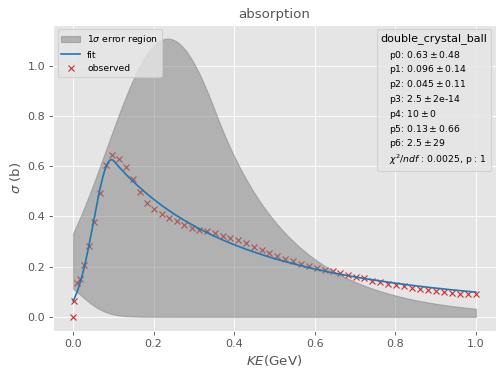

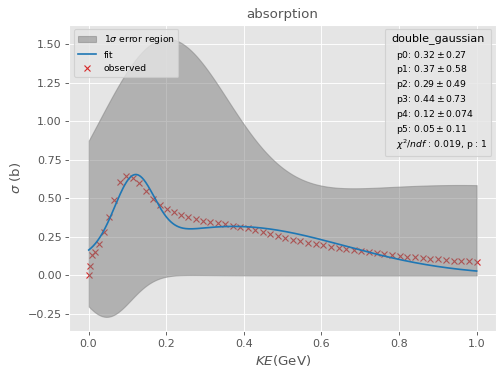

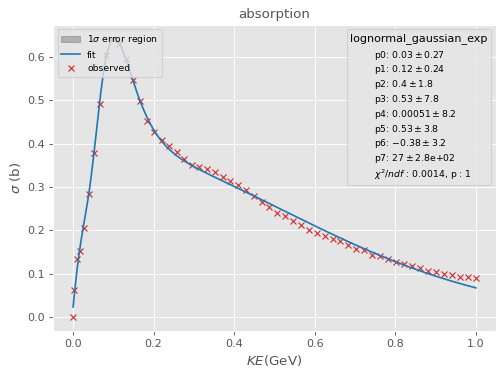

In [5]:
def FitSimulationCurve(sampling_factor : int, process : str, function : cross_section.Fitting.FitFunction):
    x = xs_sim.KE[::sampling_factor]/1000
    y = getattr(xs_sim, process)[::sampling_factor]/1000

    plt.figure()
    results = cross_section.Fitting.Fit(x, y, None, function, method = "dogbox", plot = True, xlabel = "$KE$(GeV)", ylabel = "$\sigma$ (b)", title = process)
    return results

xs_sim = cross_section.GeantCrossSections(energy_range = energy_range)

sampling_factor = 20

book = Plots.PlotBook("absorption_fit_attempts.pdf", False)
for f in [cross_section.Fitting.double_crystal_ball, cross_section.Fitting.double_gaussian, lognormal_gaussian_exp]:
    FitSimulationCurve(sampling_factor, "absorption", f)
    book.Save()
book.close()

absorption

quasielastic

/tmp/ipykernel_9023/978162520.py:10: RuntimeWarning: overflow encountered in exp
  exponential_component = np.exp(-p7 * x)
/tmp/ipykernel_9023/978162520.py:11: RuntimeWarning: overflow encountered in multiply
  return p0 * lognormal_component + p3 * gaussian_component + p6 * exponential_component # Adjust weights as needed


charge_exchange

double_charge_exchange

pion_production

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


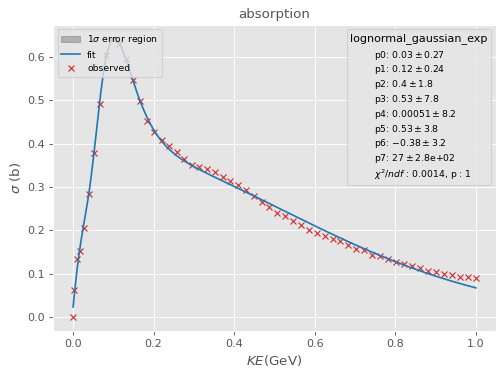

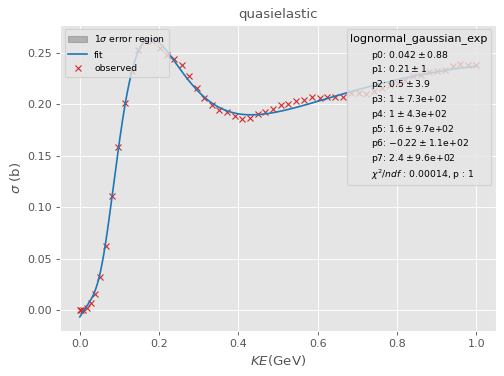

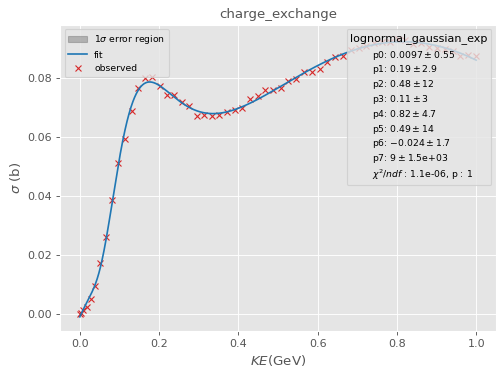

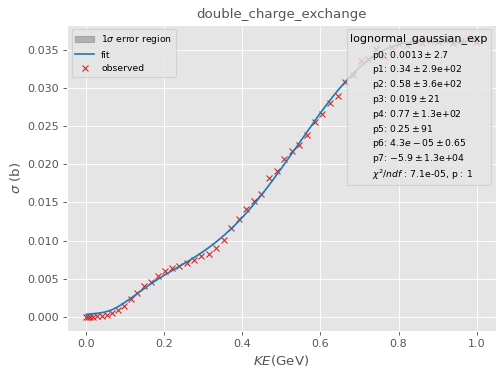

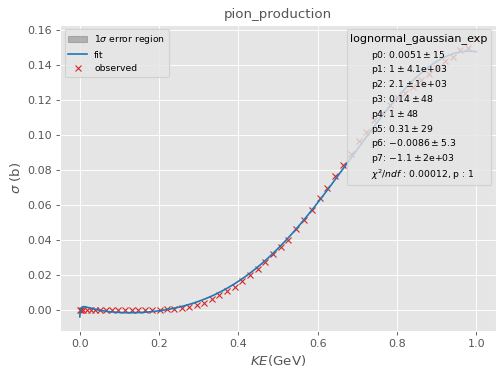

In [6]:
with Plots.PlotBook("xs_curve_fits.pdf", False) as book:
    xs_fit_results = {}
    for i in xs_sim.exclusive_processes:
        print(i)
        xs_fit_results[i] = FitSimulationCurve(20, i, lognormal_gaussian_exp)
        book.Save()

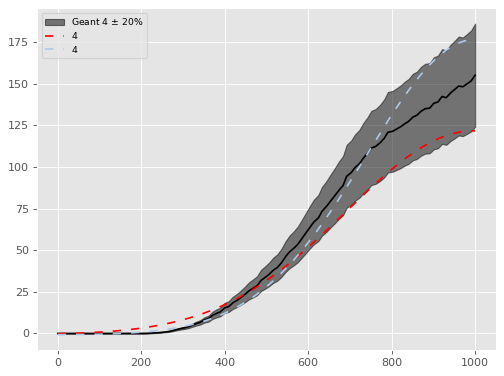

In [620]:
Plots.Plot(xs_sim.KE, xs_sim.pion_production, color = "k")
Plots.plt.fill_between(xs_sim.KE, 0.8 * xs_sim.pion_production, 1.2 * xs_sim.pion_production, alpha = 0.5, color = "k", label = "Geant 4 $\pm$ 20%")
Plots.Plot(xs_sim.KE, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *pip_low * xs_fit_results["pion_production"][0]), color = c[i], linestyle = (0, (5, 6)), newFigure = False, label = i)
Plots.Plot(xs_sim.KE, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *pip_high * xs_fit_results["pion_production"][0]), color = "C1", linestyle = (0, (5, 6)), newFigure = False, label = i)




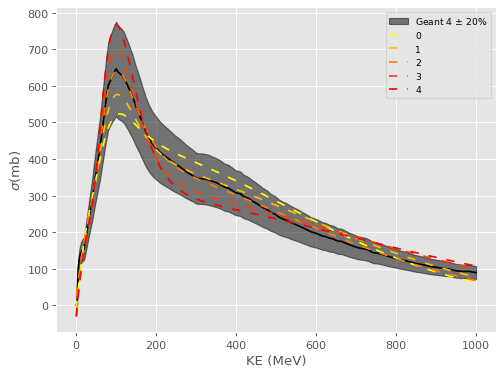

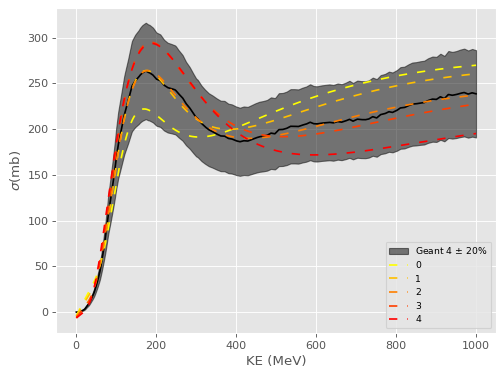

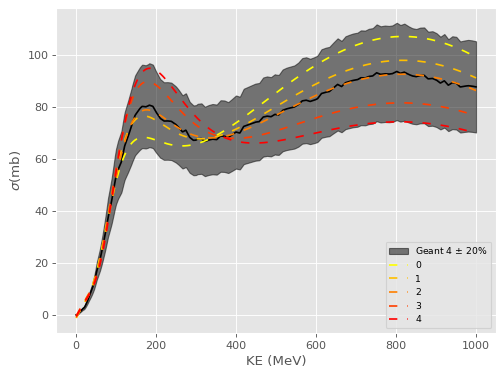

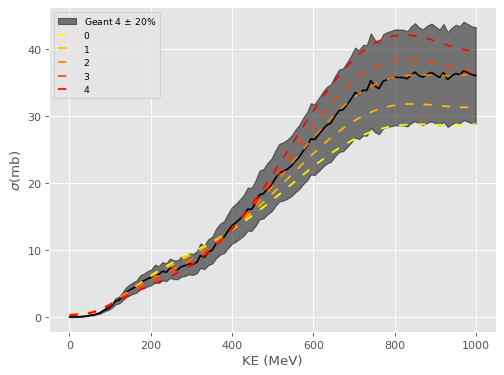

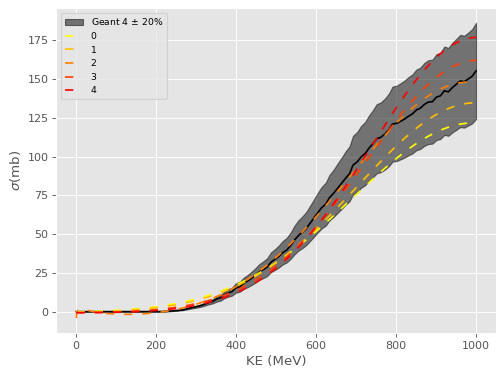

In [7]:
def CreateShapeParams(process : str, high, low):
    params = np.array(xs_fit_results[process][0])
    step = (high - low) / 100
    shape_params = []
    for i in [0, 25, 75, 100]:
        shape_params.append((low + (i *step)) * params)
    shape_params.insert(2, params)

    xs = getattr(xs_sim, process)

    Plots.Plot(xs_sim.KE, xs, color = "k", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
    Plots.plt.fill_between(xs_sim.KE, 0.8 * xs, 1.2 * xs, alpha = 0.5, color = "k", label = "Geant 4 $\pm$ 20%")

    c = Plots.plt.cm.autumn_r(np.linspace(0, 1, len(shape_params)))
    for i in range(len(shape_params)):
        Plots.Plot(xs_sim.KE, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *shape_params[i]), color = c[i], linestyle = (0, (5, 6)), newFigure = False, label = i)
    return shape_params


shape_param_factors = {
    "absorption" : [np.array([1.7, 1, 1, 1, 1, 1.3, 0.9, 1.5]), np.array([0.4, 1, 1, 1, 100, 0.9, 1.2, 1])],
    "quasielastic" : [np.array([1.8, 1.2, 1.2, 1, 1, 1, 1, 0.5]), np.array([0.45, 0.85, 0.8, 1.08, 1.15, 1, 1, 1.5])],
    "charge_exchange" : [np.array([1.5, 1.1, 1, 0.88, 1, 1.1, 1, 1]), np.array([0.7, 0.9, 1, 1.1, 1, 0.95, 1, 1])],
    "double_charge_exchange" : [np.array([0.7, 0.9, 1, 1.15, 1, 0.95, 1, 1]), np.array([1.5, 1.1, 0.95, 0.825, 1, 1.05, 1, 0.95])],
    "pion_production" : [np.array([0, 1, 1, 0.88, 1.005, 0.85, 0.1, 1]), np.array([0, 1, 1, 0.75, 1.01, 1, 0.1, 2])]
}

for k, v in shape_param_factors.items():
    CreateShapeParams(k, v[0], v[1])

In [8]:
def PlotHistShapeTest(shape_params : dict, events : int, book : Plots.PlotBook = Plots.PlotBook.null):
    config_high = CreateConfig(seed = 1, events = events, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *shape_params[-1])))
    config_low = CreateConfig(seed = 1, events = events, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *shape_params[0])))
    toys = {
    "nominal" : cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1, events = events))))),
    "high" : cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_high)))),
    "low" : cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_low))))
    }

    def ratio_err(a, b):
        return abs((a/b) * np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2))

    def RatioPlot(data):
        for _, i in Plots.IterMultiPlot(data):
            Plots.Plot(energy_overflow, data[i]["high"] / data[i]["nominal"], yerr = ratio_err(data[i]["high"], data[i]["nominal"]), color = colours["high"], label = "high", title = i, xlabel = "$N_{int}$ (MeV)", ylabel = "ratio", marker = "o", newFigure = False, linestyle = "")
            Plots.Plot(energy_overflow, data[i]["low"] / data[i]["nominal"], yerr = ratio_err(data[i]["low"], data[i]["nominal"]), color = colours["low"], label = "low", title = i, xlabel = "$N_{int}$ (MeV)", ylabel = "ratio", marker = "o", newFigure = False, linestyle = "")
            Plots.plt.axhline(1, color = "k")
            Plots.plt.ylim(0, 2)
        book.Save()
        return

    colours = {"nominal" : "k", "high" : "C6", "low" : "C0"}

    n_interact_process = {}
    for _, i in Plots.IterMultiPlot(toys["nominal"].exclusive_process):
        tmp = {}
        for k, v in toys.items():
            tmp[k] = v.NInteract(energy_slice, v.exclusive_process[i])
            Plots.Plot(energy_overflow, tmp[k] / sum(tmp[k]), yerr = np.sqrt(tmp[k]) / sum(tmp[k]), label = k, title = i, color = colours[k], xlabel = "$N_{int}$ (MeV)", ylabel = "fractional counts", style = "step", newFigure = False)
        n_interact_process[i] = tmp
    book.Save()

    RatioPlot(n_interact_process)

    n_interact_region = {}
    for _, i in Plots.IterMultiPlot(toys["nominal"].regions):
        tmp = {}
        for k, v in toys.items():
            tmp[k] = v.NInteract(energy_slice, v.regions[i])
            Plots.Plot(energy_overflow, tmp[k] / sum(tmp[k]), yerr = np.sqrt(tmp[k]) / sum(tmp[k]), label = k, color = colours[k], title = f"reco region : {i}", xlabel = "$N_{int}$ (MeV)", ylabel = "fractional counts", style = "step", newFigure = False)
        n_interact_region[i] = tmp
    book.Save()

    RatioPlot(n_interact_region)
    return

def CreateModPDFDict(KE : np.array, name : str, xs : np.array) -> dict[np.array]:
    return {
        "KE" : KE,
        name : xs
    }


In [ ]:
results = {}
true_counts = {}
expected_mus = {}

folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}

n = 1E6

# target = "absorption"
# print(target)
for target in folder:
    dire = f"test/region_fit_tests_shape_track_score/"
    with Plots.PlotBook(f"{dire}fit_results_{folder[target]}.pdf", True) as pdf:
        shape_params = CreateShapeParams(target, shape_param_factors[target][0], shape_param_factors[target][1])
        pdf.Save()
        PlotHistShapeTest(shape_params, n, pdf)
        for i, p in enumerate(shape_params):
            config = CreateConfig(seed = 1, events = n, modified_PDFs = CreateModPDFDict(xs_sim.KE, target, 1000 * lognormal_gaussian_exp(xs_sim.KE/1000, *p)))
            results[i], true_counts[i], expected_mus[i], = ModifiedConfigTest(config, energy_slice, model, toy_template, None, mean_track_score_bins)
            clear_output()
            print(target)
        PlotFitResults(f"{target} shape", model, toy_template, results, true_counts, pdf)
    Plots.plt.close("all")

In [ ]:
def ModifiedShapeTest(modified_pdf : dict[np.array], seed : int = 1):
    # cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")

    config = CreateConfig(modified_PDFs = modified_pdf, seed = seed)
    toy = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config)), smearing = True)


    try:
        result = RegionFitToyStudy(toy, model, energy_slice, mean_track_score_bins)
    except:
        result = None
    true_process_counts = {}
    for v in toy.truth_regions.columns:
        true_process_counts[v] = sum(toy.NInteract(energy_slice, toy.truth_regions[v]))
    expected_mus = [sum(toy.truth_regions[r]) / sum(toy_template.truth_regions[r]) for r in toy.truth_regions]
    plt.cla()

    KE = toy.df.KE_int
    reco_regions = toy.reco_regions
    truth_regions = toy.truth_regions

    return {
        "result" : result,
        "true_counts" : true_process_counts,
        "expected_mus" : expected_mus,
        "KE" : KE,
        "reco_regions" : reco_regions,
        "truth_regions" : truth_regions
    }


def PlotResidual(results : list[cross_section.cabinetry.model_utils.FitResults], true_counts : list[dict], labels : dict[str], book : Plots.PlotBook):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    mu = []
    mu_err = []
    for result in results:
        mu.append(result.bestfit[0:4])
        mu_err.append(result.uncertainty[0:4])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    xlabel = f"p{p}"

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = labels)
    Plots.plt.xlabel(xlabel)
    book.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i])
        Plots.plt.xticks(ticks = list(range(len(results))), labels = labels)
    book.Save()

    true_counts_pred_res = []
    true_counts_pred_res_err = []
    for n, (k, v) in enumerate(zip(labels, results)):
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")
        true_counts_pred_res_err.append(np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1])
        true_counts_pred_res.append([int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_template.reco_region_labels))])) - true_counts[n][toy_template.truth_region_labels[j]] for j in range(len(toy_template.truth_region_labels))])

    true_counts_array = np.array([list(d.values()) for d in true_counts]) # axis 0 is experiment, axis 1 is process
    true_counts_pred_res = np.array(true_counts_pred_res)
    true_counts_pred_res_err = np.array(true_counts_pred_res_err)

    for i in Plots.MultiPlot(true_counts_array.shape[1]):
        Plots.Plot(labels, true_counts_pred_res[:, i], yerr = true_counts_pred_res_err[:, i], title = f"$\mu_{n}$", xlabel = xlabel, ylabel = "predicted counts - true counts", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = list(range(len(results))), labels = labels)

    book.Save()
    return


def ModifiedPDFs(parameter_index : int, n_points : int, change : float, results : tuple, book : Plots.PlotBook) -> dict[np.array]:
    parameter_range = [-change * results[0][parameter_index], change * results[0][parameter_index]]

    x_1 = np.linspace(0, 1, 1000)

    modified_PDFs = {}

    plt.figure()
    for i in np.linspace(min(parameter_range), max(parameter_range), n_points, True):
        modified_params = np.array(results[0])
        modified_params[parameter_index] = modified_params[parameter_index] + i

        y = lognormal_gaussian_exp(x_1, *modified_params)
        if min(y) < 0:
            y = y - min(y)

        Plots.Plot(x_1*1000, y*1000, newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma$ (mb)", label = f"p{p}={modified_params[p]:.2g}")
        
        label = f"{100 * i:.2f}"

        modified_PDFs[label] = CreateModPDFDict(x_1*1000, y*1000)
    book.Save()
    return modified_PDFs


def KEPlots(KE, reco_regions, truth_regions, labels, book : Plots.PlotBook):
    # absorption_KE
    for _, t in Plots.IterMultiPlot(toy_template.truth_region_labels):
        data = [KE[i][truth_regions[i][t]] for i in range(len(labels))]
        Plots.PlotHistComparison(data, labels = labels, bins = energy_bins, xlabel = "$KE_{int}$(MeV)", title = f"process : {t}", newFigure = False)
    book.Save()

    # for i in range(len(labels)):
    #     for _, r in Plots.IterMultiPlot(toy_input.reco_region_labels):
    #         # data = [KE[i][truth_regions[i][t]] for i in range(len(labels))]
    #         tags = cross_section.Tags.ExclusiveProcessTags(truth_regions[i])
    #         for t in tags:
    #             tags[t].mask = tags[t].mask[reco_regions[i][r]]
    #         Plots.PlotTagged(KE[i][reco_regions[i][r]], cross_section.Tags.ExclusiveProcessTags(truth_regions[i]), bins = energy_bins, newFigure = False)
    #     book.Save()

    return

# * 0, 1, 4
# p = 7

for p in range(8):
    s = [1, 0.5, 0.5, 1, 500, 0.5, 1, 0.9]

    book = Plots.PlotBook(f"absorption_p{p}_study.pdf", True)
    modified_PDFs = ModifiedPDFs(p, 5, s[p], results["absorption"], book)

    outputs = {
        "result" : [],
        "true_counts" : [],
        "expected_mus" : [],
        "KE" : [],
        "reco_regions" : [],
        "truth_regions" : []

    }
    for k, pdf in modified_PDFs.items():
        print(k)
        output = ModifiedShapeTest(pdf)
        for k, v in output.items():
            outputs[k].append(v)
        clear_output()

    PlotResidual(outputs["result"], outputs["true_counts"], list(modified_PDFs.keys()), book)
    KEPlots(outputs["KE"], outputs["reco_regions"], outputs["truth_regions"], list(modified_PDFs.keys()), book)
    book.close()

In [23]:
print(outputs)

{
    'result': [None, None, None, None, None],
    'true_counts': [
        {'absorption': 14308, 'charge_exchange': 7270, 'single_pion_production': 20462, 'pion_production': 7261},
        {'absorption': 14346, 'charge_exchange': 7275, 'single_pion_production': 20462, 'pion_production': 7263},
        {'absorption': 14403, 'charge_exchange': 7273, 'single_pion_production': 20454, 'pion_production': 7263},
        {'absorption': 14437, 'charge_exchange': 7264, 'single_pion_production': 20470, 'pion_production': 7265},
        {'absorption': 14476, 'charge_exchange': 7267, 'single_pion_production': 20457, 'pion_production': 7267}
    ],
    'expected_mus': [
        [0.005126247978362432, 0.005030649082688045, 0.005074455699488389, 0.005012509462629993],
        [0.005139663778856769, 0.005034024904109793, 0.005074455699488389, 0.005013851679650379],
        [0.005159787479598274, 0.005032674575541094, 0.005072518514644149, 0.005013851679650379],
        [0.005171791090566892, 0.005026598096981948, 0.0050763928843326304, 0.005015193896670765],
        [0.005185559938442659, 0.005028623589834996, 0.005073244958960739, 0.0050165361136911505]
    ],
    'KE': [
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64
    ],
    'reco_regions': [
               absorption  charge_exchange  single_pion_production  pion_production
0           False            False                    True            False
1            True            False                   False            False
2            True            False                   False            False
3            True            False                   False            False
4            True            False                   False            False
...           ...              ...                     ...              ...
50800        True            False                   False            False
50801       False            False                    True            False
50802       False            False                    True            False
50803        True            False                   False            False
50804       False            False                   False             True

[50805 rows x 4 columns],
               absorption  charge_exchange  single_pion_production  pion_production
0           False            False                    True            False
1            True            False                   False            False
2            True            False                   False            False
3            True            False                   False            False
4            True            False                   False            False
...           ...  

# initial conditions

In [27]:
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1, events = 1E6)))))

Simulating |████████████████████████████████████████| 10/10 [100%] in 41.3s (0.24/s) 


'BeamSelectionEfficiency' executed in 0.0588s

'GenerateRecoRegions' executed in 1.7429s

'MeanTrackScore' executed in 4.6643s

'main' executed in 51.0547s

15.163779694958986

In [34]:
def PullStudy(toy_template : cross_section.Toy, model : cross_section.pyhf.Model, data_config : dict, n : int) -> dict:
    out = {"expected" : None, "scale" : pd.Series(len(toy_template.df) / data_config["events"]), "bestfit" : None, "uncertainty" : None}

    template_fractions = {s : (sum(toy_template.truth_regions[s]) / len(toy_template.df)) for s in toy_template.truth_region_labels}

    expected = []
    bestfit = []
    uncertainty = []

    for i in range(n):
        print(i)
        toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(data_config))))

        expected.append({s : (sum(toy_alt_pdf.exclusive_process[s]) / len(toy_alt_pdf.exclusive_process[s])) / template_fractions[s] for s in toy_alt_pdf.exclusive_process})

        init_params = list(np.random.uniform(0, 101, 4))

        result = cross_section.RegionFit.Fit(cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, None, model), model, init_params, [(0, np.inf)]*4, False)

        bestfit.append({list(toy_alt_pdf.exclusive_process.keys())[j] : result.bestfit[j] for j in range(len(toy_template.truth_region_labels))})
        uncertainty.append({list(toy_alt_pdf.exclusive_process.keys())[j] : result.uncertainty[j] for j in range(len(toy_template.truth_region_labels))})
        clear_output()

    out["expected"] = pd.DataFrame(expected)
    out["bestfit"] = pd.DataFrame(bestfit)
    out["uncertainty"] = pd.DataFrame(uncertainty)
    return out

config = CreateConfig(seed = None, events = 1E6, verbose = False)
out = PullStudy(toy_template, model, config, 100)

In [35]:
DictToHDF5(out, "test/1GeV_pull_study_var.hdf5")

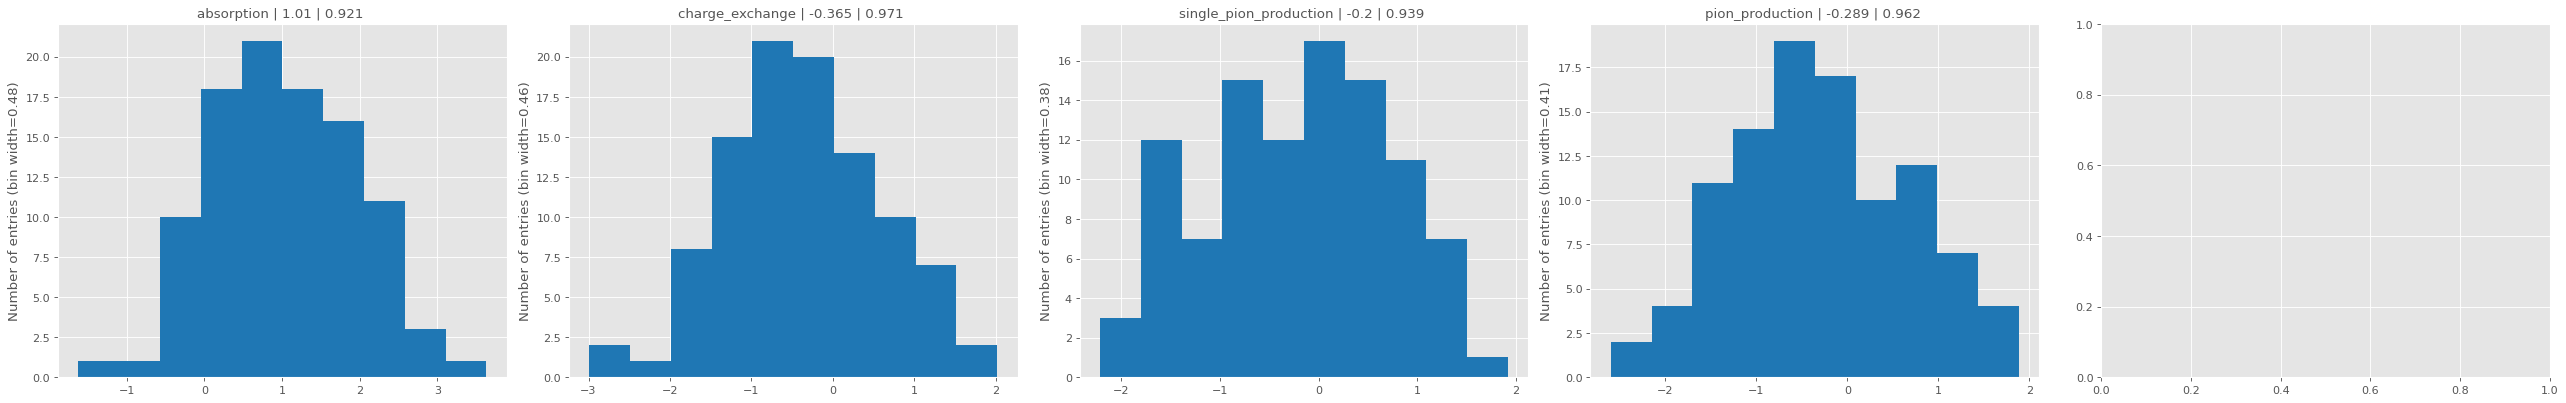

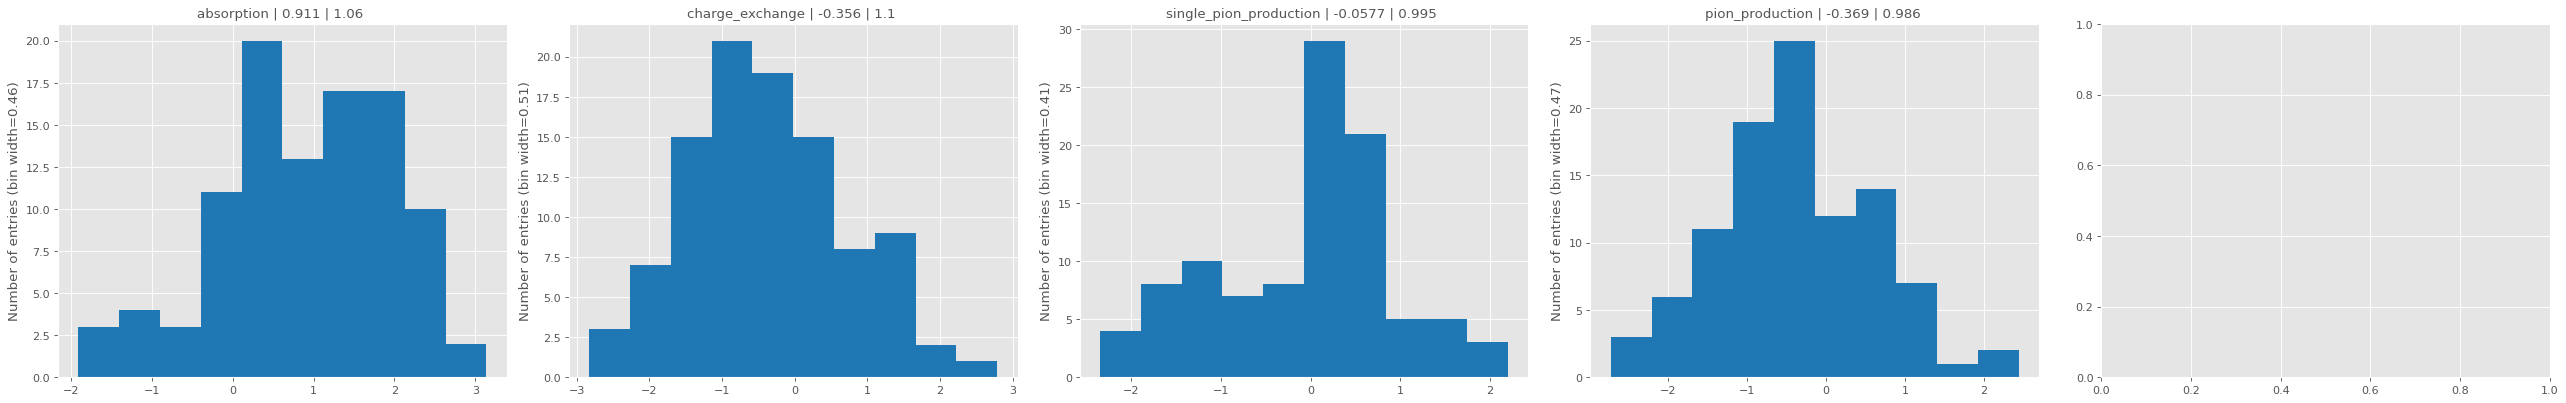

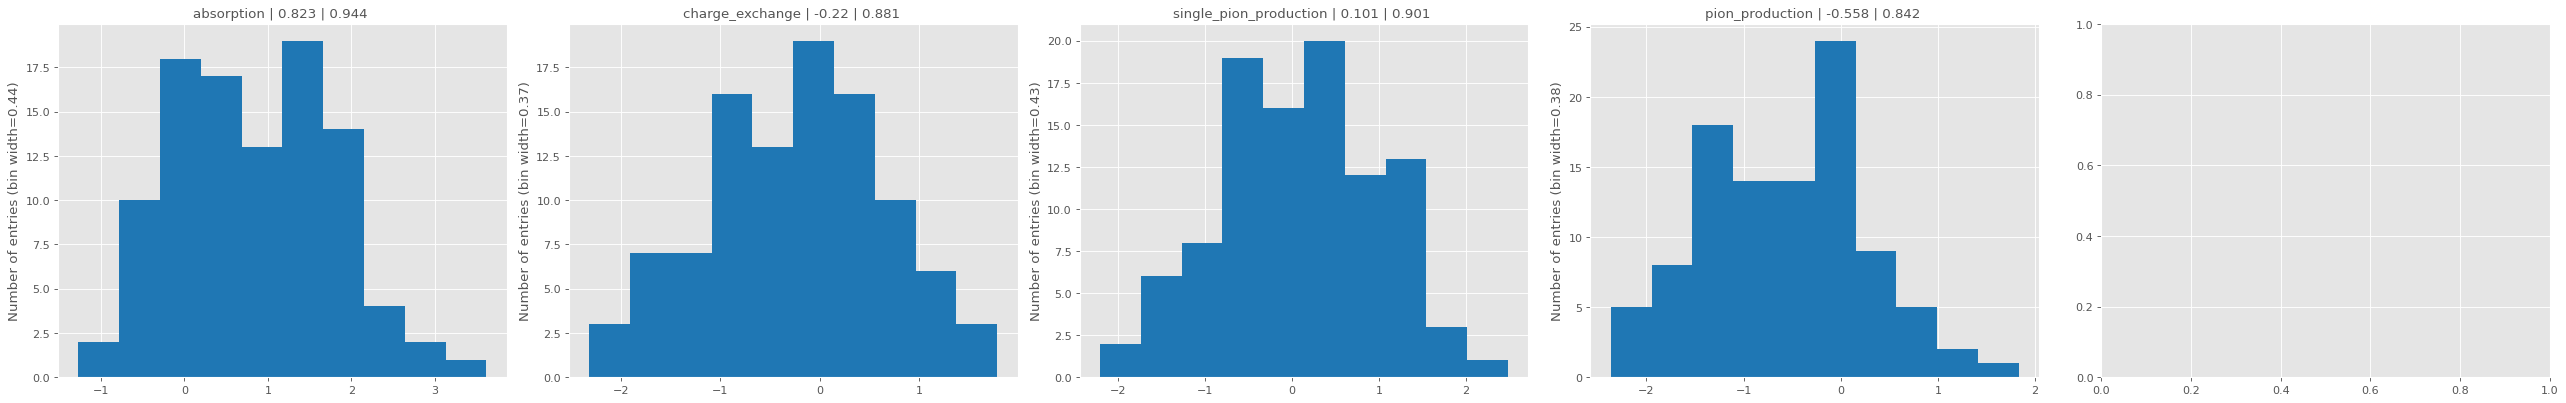

In [37]:
out = ReadHDF5("test/1GeV_pull_study.hdf5")

pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

for _, k in Plots.IterMultiPlot(pulls):
    Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", newFigure = False)


out = ReadHDF5("test/1GeV_pull_study_2.hdf5")

pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

for _, k in Plots.IterMultiPlot(pulls):
    Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", newFigure = False)

out = ReadHDF5("test/1GeV_pull_study_var.hdf5")

pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

for _, k in Plots.IterMultiPlot(pulls):
    Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", newFigure = False)

# covariance matrix

In [662]:
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1)))))
result = cross_section.RegionFit.Fit(cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, None, model), model)

Simulating |████████████████████████████████████████| 1/1 [100%] in 2.2s (0.45/s) 


'BeamSelectionEfficiency' executed in 0.0067s

'GenerateRecoRegions' executed in 0.0731s

'MeanTrackScore' executed in 0.4466s

'main' executed in 2.9503s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9611787.72236069])
init_params=None
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.00513612, 0.00528889, 0.00532074, 0.00412713])
uncertainty=array([0.00013014, 0.00023433, 0.00013323, 0.00034891])
result=FitResults(bestfit=array([0.00513612, 0.00528889, 0.00532074, 0.00412713]), uncertainty=array([0.00013014, 0.00023433, 0.00013323, 0.00034891]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.68658324 -0.57921909  0.40724318]
 [-0.68658324  1.          0.4638389  -0.59824561]
 [-0.57921909  0.4638389   1.         -0.84800042]
 [ 0.40724318 -0.59824561 -0.84800042  1.        ]], best_twice_nll=693.9193682284744, goodness_of_fit=-1, minos_uncertainty={})


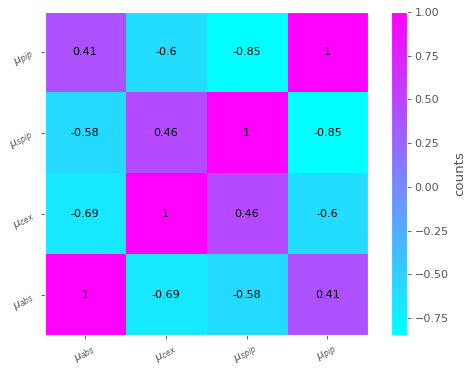

In [711]:
def PlotCorrelationMatrix(counts : np.array = None, x_labels = None, y_labels = None, title : str = None, newFigure : bool = True, cmap : str = "cool"):
    """ Plots Correlation matrix of two sets of regions.

    Args:
        true_regions (dict): true regions
        reco_regions (dict): reco regions
        title (str, optional): title. Defaults to None.
    """
    if newFigure: Plots.plt.figure()
    Plots.plt.imshow(counts, cmap = cmap, origin = "lower")
    Plots.plt.colorbar(label = "counts")

    if x_labels is None:
        x_labels = range(counts.shape[0])
    if y_labels is None:
        y_labels = range(counts.shape[1])

    Plots.plt.gca().set_xticks(np.arange(len(x_labels)), labels=x_labels)
    Plots.plt.gca().set_yticks(np.arange(len(y_labels)), labels=y_labels)

    Plots.plt.xticks(rotation = 30)
    Plots.plt.yticks(rotation = 30)

    if title is not None:
        Plots.plt.title(title)

    for (i, j), z in np.ndenumerate(counts):
        Plots.plt.gca().text(j, i, f"{z:.2g}", ha='center', va='center')
    Plots.plt.grid(False)
    Plots.plt.tight_layout()

PlotCorrelationMatrix(result.corr_mat, x_labels = ["$\mu_{abs}$", "$\mu_{cex}$", "$\mu_{spip}$", "$\mu_{pip}$"], y_labels = ["$\mu_{abs}$", "$\mu_{cex}$", "$\mu_{spip}$", "$\mu_{pip}$"])

# Computing $KE^{fit}_{int}$

In [14]:
# toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1))), smearing = True)
display(toy_observed.df.head())

,KE_init,KE_int,z_int,inclusive_process,exclusive_process,KE_int_smeared,KE_init_smeared,z_int_smeared,absorption,charge_exchange,...,beam_selection_mask,reco_regions_absorption,reco_regions_charge_exchange,reco_regions_single_pion_production,reco_regions_pion_production,truth_regions_absorption,truth_regions_charge_exchange,truth_regions_single_pion_production,truth_regions_pion_production,mean_track_score
0,891.315441,736.201402,71.0,total_inelastic,pion_production,743.184880,898.410005,70.778292,False,False,...,False,False,False,True,False,False,False,False,True,0.236870
1,841.505644,744.489148,44.5,total_inelastic,quasielastic,723.558700,821.457130,44.528440,False,False,...,False,True,False,False,False,False,False,True,False,0.684168
2,785.987938,631.485068,71.5,total_inelastic,absorption,581.923554,737.770693,72.190701,True,False,...,False,True,False,False,False,True,False,False,False,0.947994
3,902.152978,789.273232,51.5,total_inelastic,absorption,732.744631,846.069206,51.909690,True,False,...,False,False,False,True,False,True,False,False,False,0.574450
4,850.854871,778.748203,33.0,total_inelastic,absorption,773.493877,845.561731,32.863315,True,False,...,False,True,False,False,False,True,False,False,False,0.690454


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

counts_matrix=[[8463, 5, 2086, 401], [4281, 594, 682, 164], [6213, 69, 8513, 1081], [2629, 193, 2259, 831]]

total_count_actual, total_count, total_count_err=(38464, 38453.49209334142, 489.1448673382426)

$mu_0$    $mu_1$    $mu_2$   $mu_3$
value  0.008886  0.008339  0.009001  0.00964
error  0.000217  0.000345  0.000242  0.00062

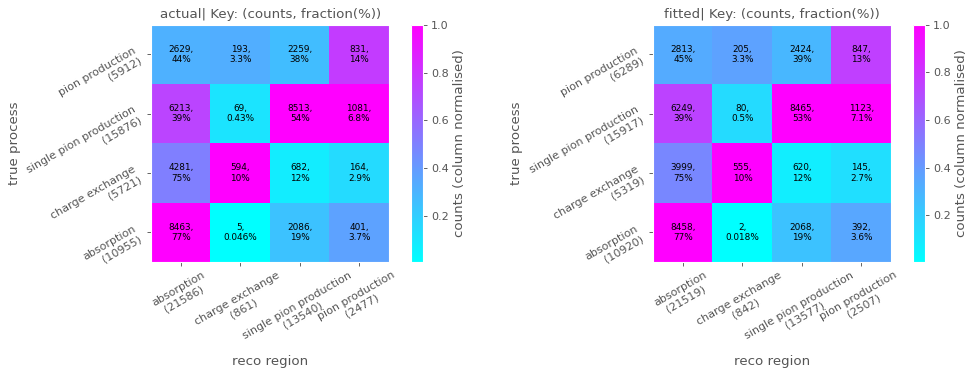

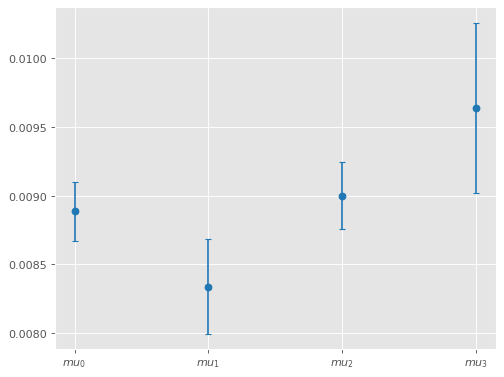

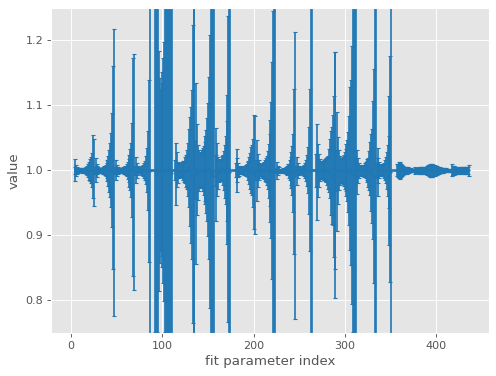

In [15]:
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins)

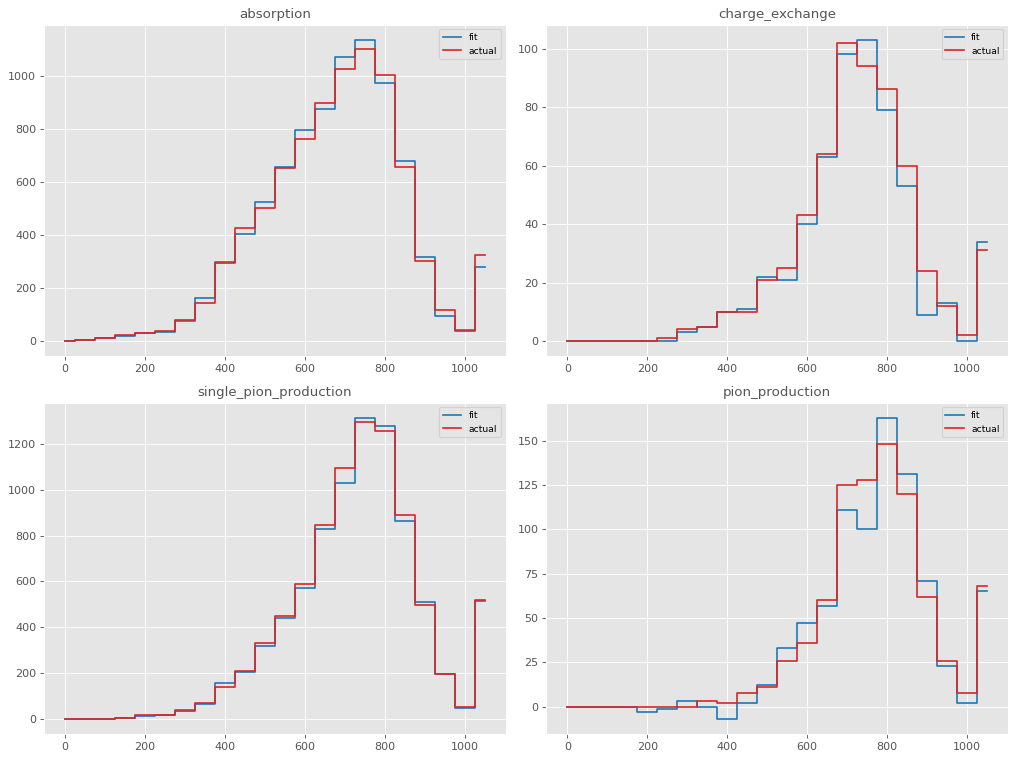

In [17]:
postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)
KE_int_prediction = SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

n = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, None)

n_fit = []
for i, (n_c, lambda_c) in enumerate(zip(n, KE_int_prediction.model_yields)):
    # print(i, n_c, lambda_c)
    n_c_fit = n_c
    for j, s in enumerate(lambda_c):
        if j == i: continue
        n_c_fit = n_c_fit - s
    n_fit.append(np.array(n_c_fit.astype(int)))

actual = [cross_section.EnergySlice.CountingExperiment(
    toy_observed.df.KE_int_smeared,
    toy_observed.df.KE_init_smeared,
    (toy_observed.df.z_int_smeared < 0) | (toy_observed.df.z_int_smeared > 700),
    toy_observed.reco_regions[l] & toy_observed.truth_regions[l] & toy_observed.df.beam_selection_mask,
    energy_slice)[2] for l in toy_observed.truth_region_labels]

# n_fit_template = [KE_int_prediction.model_yields[i][i] for i in range(len(KE_int_prediction.model_yields))]

energy_bins = np.sort(np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width))
for i in Plots.MultiPlot(len(n_fit)):
    Plots.Plot(energy_bins[::-1], n_fit[i], label = "fit", color = "C0", marker = "x", newFigure = False, style = "step")
    Plots.Plot(energy_bins[::-1], actual[i], label = "actual", color = "C6", marker = "x", title = toy_observed.truth_region_labels[i], newFigure = False, style = "step")

['absorption', 'charge_exchange', 'single_pion_production', 'pion_production']

signal: charge_exchange

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1577: RuntimeWarning: divide by zero encountered in divide
  ratio = self.y1 / self.y2
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1582: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2)


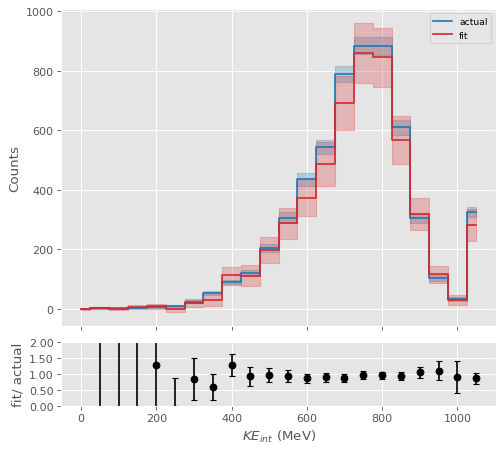

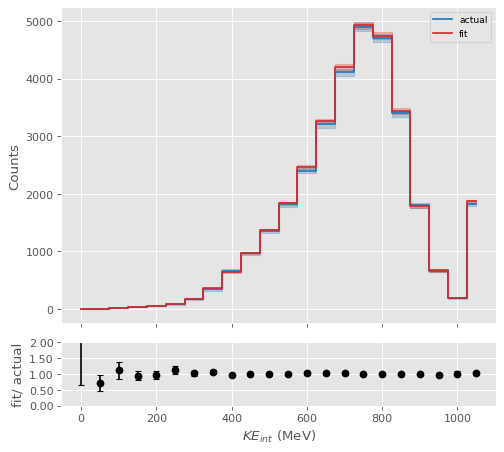

In [18]:
def PlotPrefitPostFit(prefit, prefit_err, postfit, postfit_err):
    with Plots.RatioPlot(energy_bins[::-1], postfit, prefit, postfit_err, prefit_err, "$KE_{int}$ (MeV)", "fit/ actual") as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, color = "C0", label = "actual", style = "step", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, color = "C6", label = "fit", style = "step", ylabel = "Counts", newFigure = False)

print(toy_template.truth_region_labels)
process = "charge_exchange"
print(f"signal: {process}")

N = sum(n)
# print(f"{N=}")

L = np.sum(KE_int_prediction.model_yields, 0)
# print(f"{L=}")

L_err = KE_int_prediction.total_stdev_model_bins[:, :-1] # last entry in the array is the total error for the whole channel (but we want the total error in each process)
L_err = np.sqrt(np.sum(L_err **2, 0)) # quadrature sum across all bins
# print(L_err)

L_var_bkg = sum(L_err[process != np.array(toy_template.truth_region_labels)]**2)
L_bkg = sum(L[process != np.array(toy_template.truth_region_labels)])

# print(f"{L_bkg=}")
# print(f"{L_var_bkg=}")

KE_int_fit = N - L_bkg
KE_int_fit_err = np.sqrt(N + L_var_bkg)

# print(f"{KE_int_fit=}")
# print(f"{KE_int_fit_err=}")

analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed)

actual = {l :  analysis_input.NInteract(energy_slice, analysis_input.exclusive_process[l]) for l in toy_observed.truth_region_labels}
actual_sig = actual[process]
actual_bkg = sum(np.array(list(actual.values()))[process != np.array(toy_template.truth_region_labels)])

# print(f"{actual_sig=}")
# print(f"{actual_bkg=}")

PlotPrefitPostFit(actual_sig, np.sqrt(actual_sig), KE_int_fit, KE_int_fit_err)
PlotPrefitPostFit(actual_bkg, np.sqrt(actual_bkg), L_bkg, np.sqrt(L_var_bkg))

xs_reco_fit_err=array([ 23.66636638,  17.82111865,  12.13622978,   9.59971871,
         8.62913627,   8.50574248,   8.85760466,   9.55265538,
        10.43694225,  11.59320554,  13.28769589,  14.86583797,
        16.88718608,  19.44164011,  23.03958721,  27.98394912,
        35.29228867,  46.44227161,  63.60952502, 129.57968623,
         0.        ,          nan])

(0.0, 327.91921254952456)

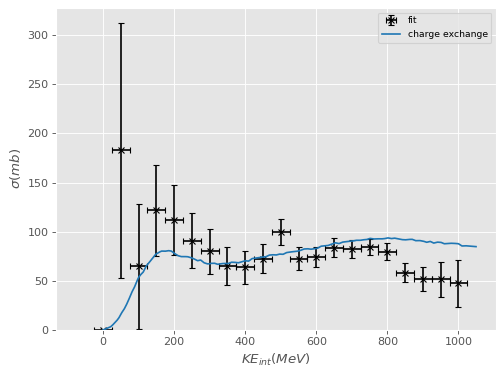

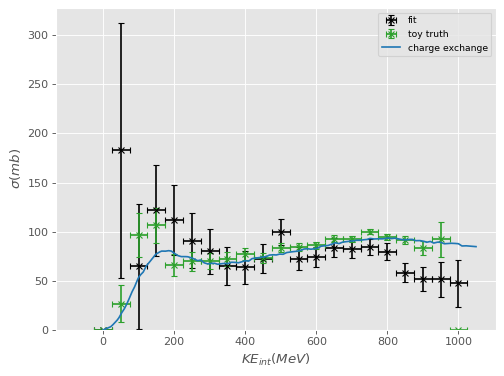

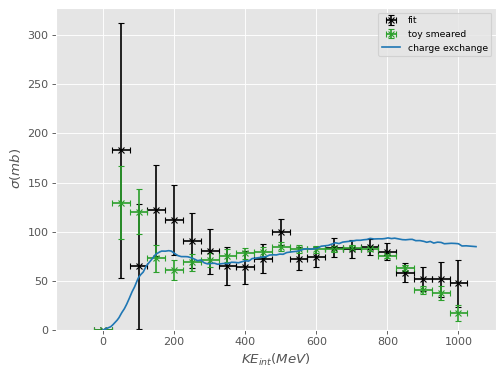

In [32]:
def XSToy(toy : cross_section.Toy, slice_dEdX : np.array, smeared : bool = False):
    KE_int = toy.df.KE_int if smeared is False else toy.df.KE_int_smeared
    KE_init = toy.df.KE_init if smeared is False else toy.df.KE_init_smeared
    outside_tpc = toy.outside_tpc if smeared is False else toy.outside_tpc_smeared

    _, n_interact_inelastic,n_interact_exclusive, n_incident = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice)

    # n_int_inc, n_inc_inc = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.df.inclusive_process != "decay", energy_slice)
    # n_int_ex = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice, interact_only = True)
    xs = cross_section.EnergySlice.CrossSection(n_interact_exclusive[1:], n_interact_inelastic[1:], n_incident[1:], slice_dEdX[1:], energy_slice.width)
    output = {"n_interact_exclusive" : n_interact_exclusive, "n_interact_inclusive" : n_interact_inelastic, "n_incident_inclusive" : n_incident, "xs" : xs[0], "xs_err" : xs[1]}
    return output


geant_xs = cross_section.GeantCrossSections(energy_range = energy_range)
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))

xs_true = XSToy(toy_observed, slice_dEdX, False)
xs_reco = XSToy(toy_observed, slice_dEdX, True) # smeared

xs_reco_fit = cross_section.EnergySlice.CrossSection(np.where(KE_int_fit < 0, 0, KE_int_fit)[1:], xs_reco["n_interact_inclusive"][1:], xs_reco["n_incident_inclusive"][1:], slice_dEdX[1:], energy_slice.width)

# xs_reco_fit_err = np.sqrt(np.array(xs_reco_fit[1]**2 + (KE_int_fit_err * xs_reco_fit[0] / KE_int_fit)**2, dtype = float))
xs_reco_fit_err = np.array(KE_int_fit_err[1:] * xs_reco_fit[0] / KE_int_fit[1:], dtype = float) # fit error accounts for statistical uncertainty as well

print(f"{xs_reco_fit_err=}")

x = energy_slice.pos[1:]

# Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_true["xs"], xerr = energy_slice.width/2, yerr = xs_true["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy truth", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_reco["xs"], xerr = energy_slice.width/2, yerr = xs_reco["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy smeared", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

In [31]:
def weighted_chi_sqr(observed, expected, uncertainties):
    return np.nansum((observed - expected)**2 / uncertainties**2) / len(observed)

sim_curve_interp = cex_toy_generator.interp1d(geant_xs.KE, getattr(geant_xs, process), fill_value = "extrapolate")(x)
weighted_chi_sqrs = {
    "truth": weighted_chi_sqr(xs_true["xs"][:-2], sim_curve_interp, xs_true["xs_err"][:-2]),
    "smeared": weighted_chi_sqr(xs_reco["xs"][:-2], sim_curve_interp, xs_reco["xs_err"][:-2]),
    "fit": weighted_chi_sqr(xs_reco_fit[0][:-1], sim_curve_interp, xs_reco_fit[1][:-1])
}
print(weighted_chi_sqrs)

{'truth': 1.2834386713268517, 'smeared': 20.436367137343048, 'fit': 33.475855250784946}

# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
    if mean_track_score_bins is not None:
        toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
    return toy_observed_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.RegionFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels)
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_template, toy_template, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_template, toy_alt, pdf_vary)
pdf_vary.close()